### Initial Imports

In [209]:
import matplotlib
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import warnings

In [182]:
population_dataset_size = 100000 # The dataset size used for calculating the overall performance metrics (how the classifier would actually perform in the wild)
experiment_dataset_size = 1000 # The dataset size that the tiny dataset will be sampled from
tiny_dataset_size = [30,50,100,200] # The size of the tiny data set

In [3]:
X_complete, y_complete = make_classification(n_samples=population_dataset_size+experiment_dataset_size,
                                             n_features=20, n_informative=2, n_redundant=2, random_state=42)

In [6]:
X_population, X_forexperiments, y_population, y_forexperiments = train_test_split(X_complete, y_complete, test_size=experiment_dataset_size, random_state=42)

X_population.shape, X_forexperiments.shape

((100000, 20), (1000, 20))

## K-Fold CV for Linear SVC


In [165]:
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import ttest_rel
import numpy as np
import warnings
import seaborn as sns
import time

In [200]:
def doKFold(param_grid, num_train, algorithm_type): 

    sample_f1 = []
    sample_recall = []
    sample_precision = []
    population_f1 = []
    population_recall = []
    population_precision = []
    difference_in_f1 = []
    difference_in_recall = []
    difference_in_precision = []
    C_List = []
    
    for j in range(num_train):
        
        best_val_f1 = -1
        best_val_recall = -1
        best_val_precision = -1
        best_model = None

        X_tiny,_,y_tiny,_ = train_test_split(X_forexperiments, y_forexperiments, train_size=tiny_size)
        
        for params in ParameterGrid(param_grid):
        
            f1_scores = []
            precision_scores = []
            recall_scores = []
            
            for train_index, test_index in kfold.split(X_tiny):
                X_train, X_test = X_tiny[train_index], X_tiny[test_index]
                y_train, y_test = y_tiny[train_index], y_tiny[test_index]
                
                clf = None
                # Fit the model on the training data
                # Make predictions on the test data
                if algorithm_type == "Logistic Regression":
                    clf = LogisticRegression(C=params['C'])
                    clf.fit(X_train, y_train)
                    predictions = clf.predict(X_test)
                    
                else:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=ConvergenceWarning)
                        clf = LinearSVC(C=params['C'], max_iter=1000)
                        clf.fit(X_train, y_train)
                        predictions = clf.predict(X_test)

                # Calculate the F1 score
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="F-score is", category=Warning)
                    val_f1 = f1_score(y_test, predictions)

                # Append the F1 score to the list
                f1_scores.append(val_f1)
                
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="Precision is", category=Warning)
                    precision_scores.append(precision_score(y_test,predictions,zero_division=0))
                    
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="Recall is", category=Warning)
                    recall_scores.append(recall_score(y_test,predictions,zero_division=0))

            #f1_scores.append(np.mean(scores))
            ## Save the best params if f1 score is better than any earlier iterations
            if np.mean(f1_scores) > best_val_f1:
                best_val_f1 = np.mean(f1_scores)
                best_val_recall = np.mean(recall_scores)
                best_val_precision = np.mean(precision_scores)
                best_params = params
                
                
        # Train a new model with the best params and make predictions
        if algorithm_type == "Logistic Regression":
            best_model = LogisticRegression(C=best_params['C'])
            best_model.fit(X_tiny,y_tiny)
            predictions = best_model.predict(X_population)
            
        else:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                best_model = LinearSVC(C=best_params['C'], max_iter=1000)
                best_model.fit(X_tiny,y_tiny)
                predictions = best_model.predict(X_population)
            
        C_List.append(best_params['C'])

        
        #calculate the population f1 score and difference in estimate between evaluation method and population
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="F-score is", category=Warning)
            pop_f1 = f1_score(y_population, predictions, zero_division=0)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Recall is", category=Warning)
            pop_recall = recall_score(y_population, predictions, zero_division=0)
            
            
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Precision is", category=Warning)    
            pop_precision = precision_score(y_population, predictions, zero_division=0)
            
        sample_f1.append(best_val_f1)
        sample_recall.append(best_val_recall)
        sample_precision.append(best_val_precision)
         
        population_f1.append(pop_f1)
        population_recall.append(pop_recall)
        population_precision.append(pop_precision)
        
        difference_in_f1.append(best_val_f1 - pop_f1)
        difference_in_recall.append(best_val_recall - pop_recall)
        difference_in_precision.append(best_val_precision - pop_precision)
        
    #Run a t test to determine if sample f1 and population f1s have statistically significant difference
    t_statistic, p_value = ttest_rel(sample_f1, population_f1)
        
    return np.mean(population_f1), np.mean(difference_in_f1), difference_in_f1, p_value, np.mean(population_recall), \
            np.mean(difference_in_recall), np.mean(population_precision), np.mean(difference_in_precision), C_List
        


In [201]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['num k folds', 'dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    
    num_folds = [2,5,10,20,tiny_size]
    for i in num_folds:
        
        print('Num Folds: ', i)

        tic = time.perf_counter()
        
        kfold = KFold(n_splits=i, shuffle=True, random_state=42)
        average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doKFold(param_grid, num_train = 1000, algorithm_type = "Linear SVC")
        # Create a new row of data as a dictionary
        toc = time.perf_counter()
        run_time = toc-tic
        new_row_data = {
            'num k folds': i,
            'average model f1': average_model_f1,
            'average difference in f1 estimate': f1_diff,
            'differences in f1 estimate':all_f1_diff,
            'f1 p-value': f1_p_value,
            'average model recall': average_model_recall,
            'difference in recall estimate': recall_diff,
            'average model precision': average_model_precision,
            'difference in precision estimate': precision_diff,
            'dataset size': tiny_size,
            'best parameter': C_List,
            'time': run_time
            
        }

    # Add the new row to the DataFrame using the loc attribute
        df.loc[len(df)] = new_row_data
df
    
    

Current Loop:  30
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  30
Current Loop:  50
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  50
Current Loop:  100
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  100
Current Loop:  200
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  200


,num k folds,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,2,30,0.784187,-0.011523,"[0.005562355057332602, -0.11242884250474372, -...",9.719099e-04,0.778734,0.002074,0.793178,-0.000470,"[0.01, 1, 0.01, 1, 0.01, 0.01, 1, 1, 0.01, 0.0...",100.271550
1,5,30,0.787542,-0.015855,"[0.010271830899906242, -0.020506006070497906, ...",2.598156e-05,0.779866,0.011914,0.798999,0.007371,"[0.01, 0.05, 1, 0.05, 0.01, 0.01, 0.1, 0.1, 0....",119.345806
2,10,30,0.786271,-0.087005,"[-0.03152713504417326, -0.11725677705410498, 0...",1.206102e-84,0.778739,-0.061922,0.797504,-0.073187,"[0.01, 0.01, 0.1, 0.01, 0.01, 0.05, 1, 0.05, 0...",156.037080
3,20,30,0.787024,-0.285874,"[-0.21407847341741193, -0.29843486218267307, -...",0.000000e+00,0.781179,-0.275229,0.796569,-0.287744,"[0.05, 5, 0.01, 0.01, 0.01, 0.05, 0.01, 0.05, ...",230.579851
4,30,30,0.789468,-0.382301,"[-0.4608215103894538, -0.39982016849430213, -0...",0.000000e+00,0.782841,-0.375675,0.799563,-0.392396,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.0...",300.074445
5,2,50,0.811175,-0.009935,"[-0.026364041825660323, -0.027910495691545467,...",9.748051e-05,0.799745,0.002322,0.825013,-0.007937,"[0.01, 0.01, 0.01, 0.01, 0.01, 1, 1, 0.01, 0.0...",103.857784
6,5,50,0.809761,0.001194,"[-0.027227643443113014, 0.029776273367652317, ...",6.261829e-01,0.799159,0.018495,0.823178,0.015484,"[0.1, 0.01, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01...",128.015680
7,10,50,0.807874,-0.024706,"[-0.07813948120148895, 0.027621707008572027, 0...",2.525975e-16,0.798629,0.002563,0.820205,-0.003925,"[0.01, 0.01, 5, 0.01, 0.01, 0.01, 0.05, 0.05, ...",169.763800
8,20,50,0.808090,-0.140237,"[-0.09184810271367705, -0.31576050074236367, -...",2.701088e-237,0.797357,-0.116207,0.821530,-0.135722,"[0.01, 0.01, 0.01, 0.05, 0.01, 0.05, 0.01, 0.0...",257.594094
9,50,50,0.812647,-0.385747,"[-0.3721655316506845, -0.4150355923375195, -0....",0.000000e+00,0.799272,-0.372372,0.828711,-0.401811,"[0.01, 0.1, 0.05, 0.01, 0.01, 1, 0.05, 0.01, 0...",418.009280


In [539]:
def barChartDifference(df, algorithm_type, categories, CV_Type, title_type):   
    # Group the data by 'dataset size'
    grouped_df = df.groupby('dataset size')

    # Get the unique 'num k folds' values
    categories_unique = df[categories].unique()

    # Set the width of each bar
    bar_width = 0.2

    # Create a figure and axis for the graph
    fig, ax = plt.subplots(figsize=(14,7))

    # Generate a colormap with distinct colors for each 'num k folds' value
    categories_colors = sns.color_palette('rocket', len(categories_unique))
    
    loov_color = True

    # Custom legend handler to display unique labels and colors in the legend
    legend_elements = []
    for i, category in enumerate(categories_unique):
        filtered_df = df[df[categories] == category]
        if not filtered_df.empty:
            if category in [30,50,100,200]:
                if loov_color:
                    color = categories_colors[4]
                    legend_elements.append(plt.bar(0, 0, color=color, label=f'LOOV'))
                    loov_color = False
            else:
                color = categories_colors[i]
                legend_elements.append(plt.bar(0, 0, color=color, label=f'{category} ' + CV_Type))

    # Loop through each dataset size group and plot the bars for each 'num k folds'
    x_positions = np.arange(len(grouped_df)) * (len(categories_unique) + 1) * bar_width
    for i, (size, size_group) in enumerate(grouped_df):
        num_empty = 0
        for j, category in enumerate(categories_unique):
            filtered_df = size_group[size_group[categories] == category]

            if filtered_df.empty:
                num_empty = num_empty + 1

            # Check if there are records for the current 'num k folds' in the current dataset size group
            if not filtered_df.empty:
                x_pos = x_positions[i] + bar_width * (j - num_empty)
                if j > 4:
                    ax.bar(x_pos, filtered_df['average difference in f1 estimate'].values[0], bar_width, color=categories_colors[4])
                else:
                    ax.bar(x_pos, filtered_df['average difference in f1 estimate'].values[0], bar_width, color=categories_colors[j])

    # Set the x-axis labels as 'dataset size'
    ax.set_xticks(x_positions + (len(categories_unique) - 1) * bar_width / 2)
    ax.set_xticklabels([str(size) for size, _ in grouped_df], fontsize=14)

    # Set the y-axis label
    ax.set_ylabel('Difference in F1 Estimate', fontsize=14)
    ax.set_xlabel('Dataset Size', fontsize=14)

    # Set the title for the graph
    ax.set_title('Difference in F1 Estimate by Dataset Size and Number of ' + title_type, fontsize=16)

    # Add the custom legend at the bottom left
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=14) 

    # Show the plot
    plt.tight_layout()
    plt.show()


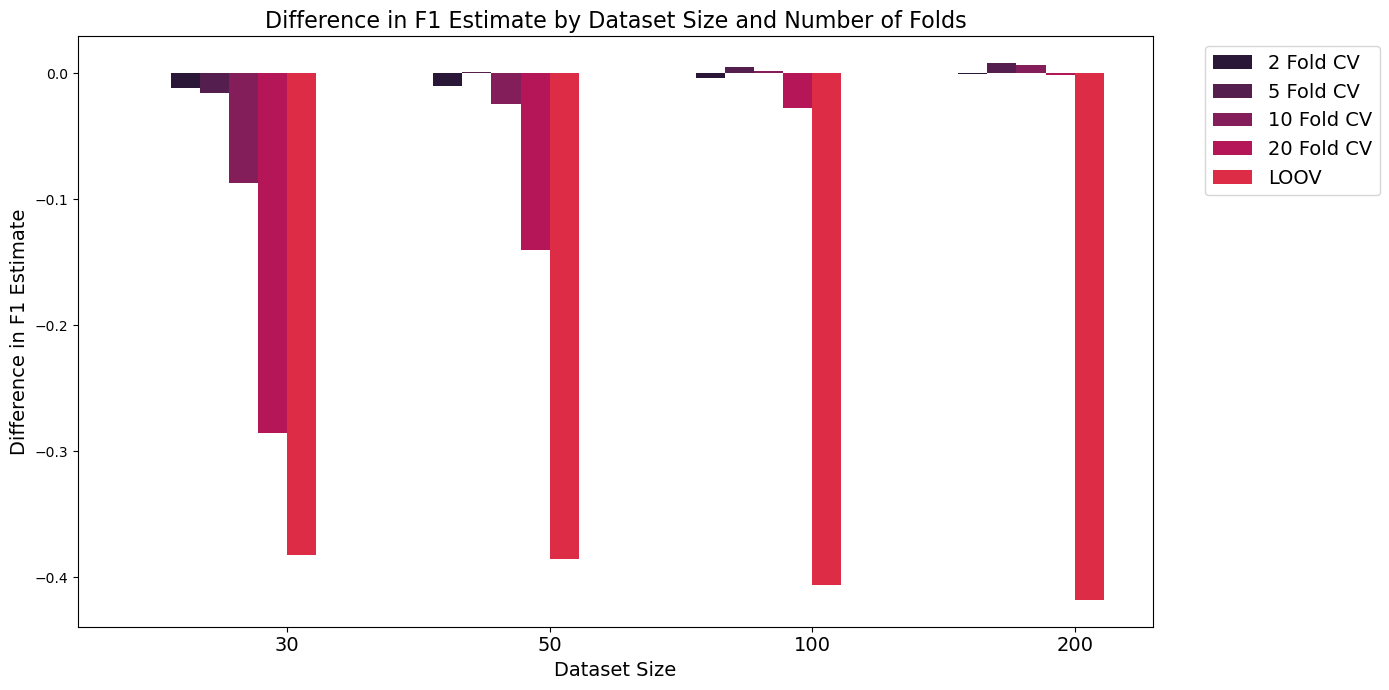

In [540]:
barChartDifference(df, 'Linear SVC', 'num k folds', 'Fold CV', 'Folds')

## K Fold for Logistic Regression

In [206]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['num k folds', 'dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df2 = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    
    num_folds = [2,5,10,20,tiny_size]
    for i in num_folds:
        
        print('Num Folds: ', i)

        tic = time.perf_counter()
        
        kfold = KFold(n_splits=i, shuffle=True, random_state=42)
        average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doKFold(param_grid, num_train = 1000, algorithm_type = "Logistic Regression")
        # Create a new row of data as a dictionary
        toc = time.perf_counter()
        run_time = toc-tic
        new_row_data = {
            'num k folds': i,
            'average model f1': average_model_f1,
            'average difference in f1 estimate': f1_diff,
            'differences in f1 estimate':all_f1_diff,
            'f1 p-value': f1_p_value,
            'average model recall': average_model_recall,
            'difference in recall estimate': recall_diff,
            'average model precision': average_model_precision,
            'difference in precision estimate': precision_diff,
            'dataset size': tiny_size,
            'best parameter': C_List,
            'time': run_time
            
        }

    # Add the new row to the DataFrame using the loc attribute
        df2.loc[len(df2)] = new_row_data
df2
    
    

Current Loop:  30
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  30
Current Loop:  50
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  50
Current Loop:  100
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  100
Current Loop:  200
Num Folds:  2
Num Folds:  5
Num Folds:  10
Num Folds:  20
Num Folds:  200


,num k folds,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,2,30,0.767911,-0.039510,"[-0.25401410414757564, -0.09638841039735224, -...",1.514226e-19,0.761635,-0.005680,0.794689,-0.025934,"[5, 1, 0.1, 0.1, 5, 1, 1, 5, 0.05, 1, 1, 0.1, ...",113.106093
1,5,30,0.770892,-0.018350,"[0.032158259757174346, -0.04823424818606792, 0...",3.998143e-06,0.767018,0.002682,0.797182,0.009371,"[0.05, 1, 0.1, 0.1, 5, 0.1, 1, 1, 0.05, 1, 1, ...",146.916704
2,10,30,0.768688,-0.087521,"[-0.21237589145380475, -0.01847565304879495, -...",1.277177e-77,0.762771,-0.069571,0.799186,-0.079086,"[0.05, 0.05, 0.05, 0.05, 0.1, 1, 1, 0.1, 0.1, ...",227.973712
3,20,30,0.759703,-0.243803,"[-0.27347963445481377, -0.2155694481505483, -0...",1.993221e-299,0.736089,-0.221239,0.822207,-0.288807,"[5, 1, 0.1, 0.05, 1, 0.01, 0.01, 0.05, 5, 0.05...",316.889674
4,30,30,0.747221,-0.330055,"[-0.4523096379793046, -0.32698757775399034, -0...",0.000000e+00,0.718907,-0.301740,0.827102,-0.409935,"[0.05, 1, 1, 0.01, 0.1, 0.01, 0.1, 1, 0.05, 1,...",383.202872
5,2,50,0.798734,-0.016962,"[-0.14418078476370477, -0.04371714211841771, -...",5.561695e-09,0.787727,0.000762,0.819308,-0.007332,"[0.05, 0.1, 5, 0.1, 1, 1, 5, 0.1, 1, 5, 1, 0.0...",120.952285
6,5,50,0.801389,-0.000003,"[-0.00045122651571072314, -0.01917598907447559...",9.990874e-01,0.794916,0.018481,0.818476,0.018121,"[5, 1, 0.05, 0.05, 0.1, 1, 0.1, 1, 0.1, 1, 5, ...",161.356280
7,10,50,0.802837,-0.024396,"[-0.19323844659874667, 0.002850232007108433, -...",4.130347e-16,0.793523,-0.000178,0.823697,-0.002685,"[0.1, 0.05, 0.05, 5, 0.05, 0.05, 0.05, 0.01, 0...",225.318675
8,20,50,0.800949,-0.137975,"[-0.2923564649872309, -0.08158141253716977, -0...",4.691960e-217,0.785413,-0.114288,0.831475,-0.139783,"[0.1, 1, 0.05, 1, 0.05, 0.01, 0.05, 0.05, 0.1,...",321.263400
9,50,50,0.790347,-0.362167,"[-0.4613666689661289, -0.49282695176529095, -0...",0.000000e+00,0.758060,-0.329880,0.851839,-0.423659,"[1, 1, 0.01, 1, 0.1, 0.05, 1, 5, 0.01, 0.05, 0...",535.744151


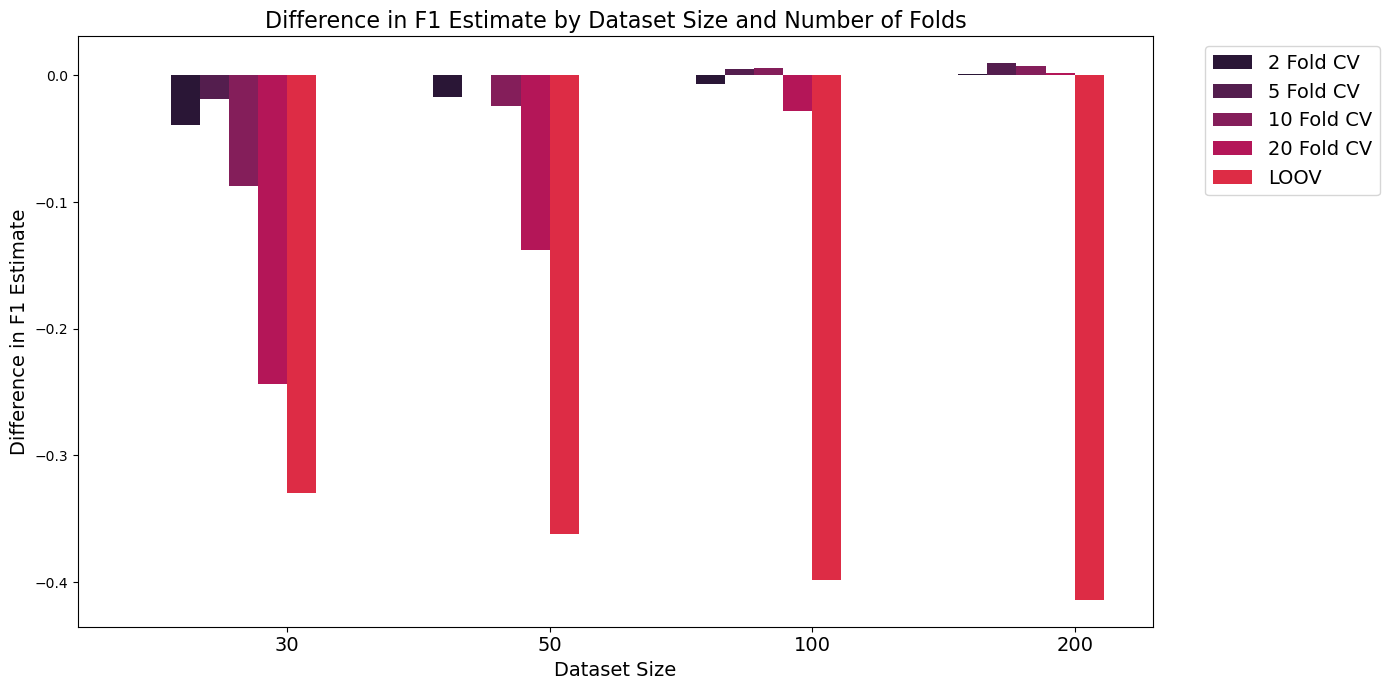

In [541]:
barChartDifference(df2, 'Logistic Regression', 'num k folds', 'Fold CV', 'Folds')

## Monte Carlo CV for Linear SVC

In [210]:
def doMonteCarlo(param_grid, num_train, algorithm_type): 

    sample_f1 = []
    sample_recall = []
    sample_precision = []
    population_f1 = []
    population_recall = []
    population_precision = []
    difference_in_f1 = []
    difference_in_recall = []
    difference_in_precision = []
    C_List = []
    
    for j in range(num_train):
        
        best_val_f1 = -1
        best_val_recall = -1
        best_val_precision = -1
        best_model = None

        X_tiny,_,y_tiny,_ = train_test_split(X_forexperiments, y_forexperiments, train_size=tiny_size)
        
        for params in ParameterGrid(param_grid):
        
            f1_scores = []
            precision_scores = []
            recall_scores = []
            
            for train_index, test_index in shuffle_split.split(X_tiny):
                X_train, X_test = X_tiny[train_index], X_tiny[test_index]
                y_train, y_test = y_tiny[train_index], y_tiny[test_index]
                
                clf = None
                # Fit the model on the training data
                # Make predictions on the test data
                if algorithm_type == "Logistic Regression":
                    clf = LogisticRegression(C=params['C'])
                    clf.fit(X_train, y_train)
                    predictions = clf.predict(X_test)
                    
                else:
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=ConvergenceWarning)
                        clf = LinearSVC(C=params['C'], max_iter=1000)
                        clf.fit(X_train, y_train)
                        predictions = clf.predict(X_test)

                # Calculate the F1 score
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="F-score is", category=Warning)
                    val_f1 = f1_score(y_test, predictions)

                # Append the F1 score to the list
                f1_scores.append(val_f1)
                
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="Precision is", category=Warning)
                    precision_scores.append(precision_score(y_test,predictions,zero_division=0))
                    
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="Recall is", category=Warning)
                    recall_scores.append(recall_score(y_test,predictions,zero_division=0))

            #f1_scores.append(np.mean(scores))
            ## Save the best params if f1 score is better than any earlier iterations
            if np.mean(f1_scores) > best_val_f1:
                best_val_f1 = np.mean(f1_scores)
                best_val_recall = np.mean(recall_scores)
                best_val_precision = np.mean(precision_scores)
                best_params = params
                
                
        # Train a new model with the best params and make predictions
        if algorithm_type == "Logistic Regression":
            best_model = LogisticRegression(C=best_params['C'])
            best_model.fit(X_tiny,y_tiny)
            predictions = best_model.predict(X_population)
            
        else:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                best_model = LinearSVC(C=best_params['C'], max_iter=1000)
                best_model.fit(X_tiny,y_tiny)
                predictions = best_model.predict(X_population)
            
        C_List.append(best_params['C'])

        
        #calculate the population f1 score and difference in estimate between evaluation method and population
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="F-score is", category=Warning)
            pop_f1 = f1_score(y_population, predictions, zero_division=0)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Recall is", category=Warning)
            pop_recall = recall_score(y_population, predictions, zero_division=0)
            
            
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Precision is", category=Warning)    
            pop_precision = precision_score(y_population, predictions, zero_division=0)
            
        sample_f1.append(best_val_f1)
        sample_recall.append(best_val_recall)
        sample_precision.append(best_val_precision)
         
        population_f1.append(pop_f1)
        population_recall.append(pop_recall)
        population_precision.append(pop_precision)
        
        difference_in_f1.append(best_val_f1 - pop_f1)
        difference_in_recall.append(best_val_recall - pop_recall)
        difference_in_precision.append(best_val_precision - pop_precision)
        
    #Run a t test to determine if sample f1 and population f1s have statistically significant difference
    t_statistic, p_value = ttest_rel(sample_f1, population_f1)
        
    return np.mean(population_f1), np.mean(difference_in_f1), difference_in_f1, p_value, np.mean(population_recall), \
            np.mean(difference_in_recall), np.mean(population_precision), np.mean(difference_in_precision), C_List
        


In [215]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['num splits', 'dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df3 = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    
    num_splits = [2,5,10,20]
    for i in num_splits:
        
        print('Num Splits: ', i)

        tic = time.perf_counter()
        
        shuffle_split = ShuffleSplit(n_splits=i, test_size=0.2, random_state=42)
        average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doMonteCarlo(param_grid, num_train = 1000, algorithm_type = "Linear SVC")
        # Create a new row of data as a dictionary
        toc = time.perf_counter()
        run_time = toc-tic
        new_row_data = {
            'num splits': i,
            'average model f1': average_model_f1,
            'average difference in f1 estimate': f1_diff,
            'differences in f1 estimate':all_f1_diff,
            'f1 p-value': f1_p_value,
            'average model recall': average_model_recall,
            'difference in recall estimate': recall_diff,
            'average model precision': average_model_precision,
            'difference in precision estimate': precision_diff,
            'dataset size': tiny_size,
            'best parameter': C_List,
            'time': run_time
            
        }

    # Add the new row to the DataFrame using the loc attribute
        df3.loc[len(df3)] = new_row_data
df3
    
    

Current Loop:  30
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  50
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  100
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  200
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20


,num splits,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,2,30,0.788303,-0.005869,"[0.025109922424174536, -0.014997873834317277, ...",2.799106e-01,0.780944,0.015148,0.799302,0.022939,"[0.01, 0.01, 0.01, 0.01, 0.05, 0.01, 0.01, 0.0...",100.477120
1,5,30,0.785801,-0.011626,"[0.08644528480264702, 0.18542728550738485, -0....",7.159198e-03,0.779299,0.014498,0.796000,0.013000,"[0.05, 5, 0.01, 0.05, 0.01, 0.05, 0.1, 0.05, 0...",121.633381
2,10,30,0.786468,-0.014459,"[-0.054410414427569775, -0.09133505026245692, ...",1.607845e-04,0.780020,0.014810,0.796554,0.006572,"[0.01, 0.01, 0.01, 0.05, 0.01, 0.1, 0.01, 0.01...",160.490555
3,20,30,0.789359,-0.024806,"[-0.25013297614843044, -0.09006069546532813, 0...",2.046793e-13,0.780663,0.006755,0.801569,-0.004578,"[0.01, 0.01, 0.1, 0.1, 0.05, 0.01, 0.01, 0.01,...",256.835962
4,2,50,0.810051,0.013693,"[0.10795532747399672, -0.00124689863746541, 0....",8.767366e-05,0.800890,0.028829,0.821932,0.031753,"[0.01, 0.01, 0.01, 1, 0.01, 0.01, 0.01, 0.01, ...",111.995025
5,5,50,0.808695,0.001370,"[-0.08446679982062777, 0.02756043937065522, 0....",6.225192e-01,0.798646,0.018531,0.821301,0.016694,"[1, 0.01, 0.01, 0.01, 0.05, 5, 0.01, 0.01, 0.0...",138.490077
6,10,50,0.811995,-0.000259,"[0.00653947024871504, -0.0002030751837399647, ...",9.119327e-01,0.801612,0.018914,0.824987,0.013070,"[0.01, 0.01, 0.05, 0.01, 0.01, 0.01, 0.01, 0.0...",182.466071
7,20,50,0.813734,-0.008587,"[0.00011966828174325705, -0.012558102634803836...",3.281603e-04,0.803952,0.009459,0.825806,0.007767,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.01, 0.1...",269.569600
8,2,100,0.833072,0.014678,"[-0.06483224597203108, -0.07543046476512871, 0...",2.489939e-11,0.820018,0.025465,0.847903,0.017800,"[0.01, 1, 5, 1, 0.05, 1, 0.01, 0.01, 1, 0.01, ...",119.003812
9,5,100,0.833602,0.007001,"[0.06676387464225375, -0.016143741540373124, -...",6.893241e-05,0.820380,0.020295,0.848553,0.007662,"[5, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, ...",153.874977


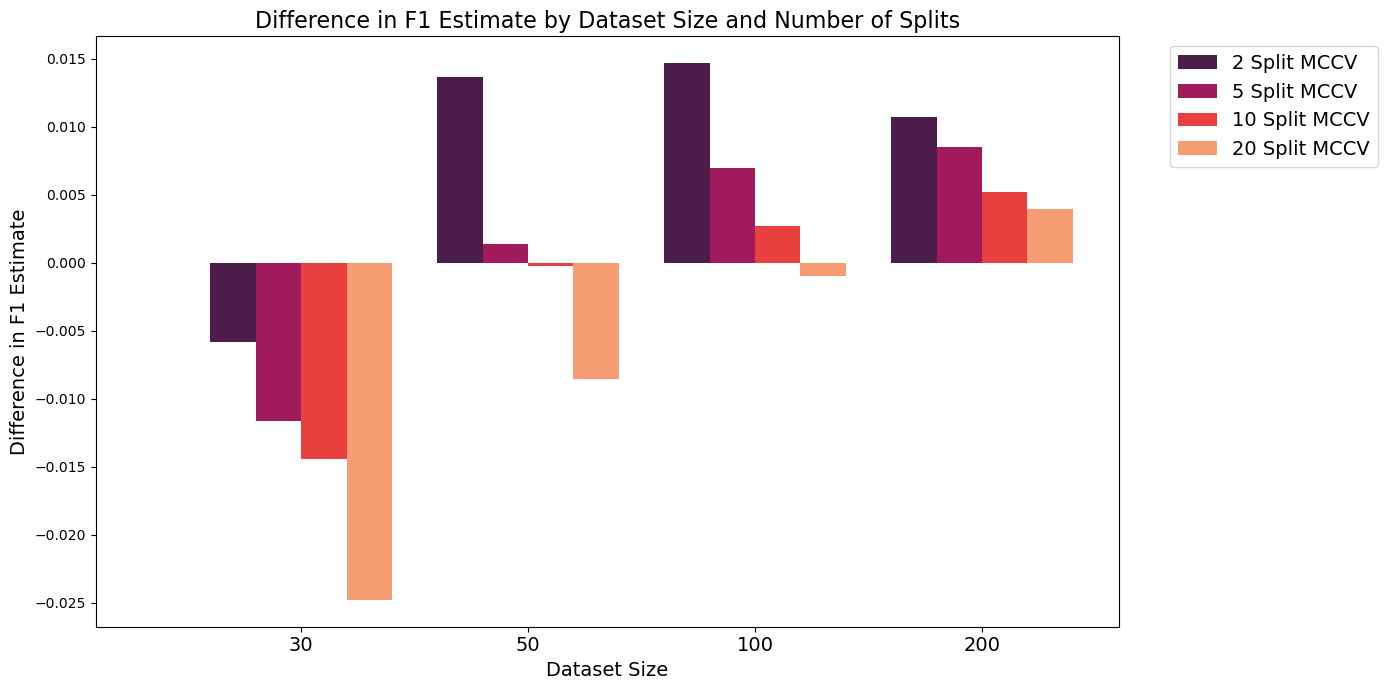

In [542]:
barChartDifference(df3, 'Linear SVC', 'num splits', 'Split MCCV', 'Splits')

## Monte Carlo for Logistic Regression

In [222]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['num splits', 'dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df4 = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    
    num_splits = [2,5,10,20]
    for i in num_splits:
        
        print('Num Splits: ', i)

        tic = time.perf_counter()
        
        shuffle_split = ShuffleSplit(n_splits=i, test_size=0.2, random_state=42)
        average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doMonteCarlo(param_grid, num_train = 1000, algorithm_type = "Logistic Regression")
        # Create a new row of data as a dictionary
        toc = time.perf_counter()
        run_time = toc-tic
        new_row_data = {
            'num splits': i,
            'average model f1': average_model_f1,
            'average difference in f1 estimate': f1_diff,
            'differences in f1 estimate':all_f1_diff,
            'f1 p-value': f1_p_value,
            'average model recall': average_model_recall,
            'difference in recall estimate': recall_diff,
            'average model precision': average_model_precision,
            'difference in precision estimate': precision_diff,
            'dataset size': tiny_size,
            'best parameter': C_List,
            'time': run_time
            
        }

    # Add the new row to the DataFrame using the loc attribute
        df4.loc[len(df4)] = new_row_data
df4
    
    

Current Loop:  30
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  50
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  100
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20
Current Loop:  200
Num Splits:  2
Num Splits:  5
Num Splits:  10
Num Splits:  20


,num splits,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,2,30,0.752342,0.017518,"[0.10779014408676746, -0.026270986844318722, 0...",7.965785e-04,0.763870,0.025413,0.784920,0.033546,"[0.1, 1, 0.05, 0.05, 1, 0.01, 0.05, 0.05, 0.05...",105.935328
1,5,30,0.766686,-0.011550,"[-0.1211744490399409, -0.13878816967947905, -0...",7.342963e-03,0.762365,0.008598,0.797537,0.011366,"[1, 1, 5, 1, 1, 0.1, 1, 0.05, 5, 0.1, 0.05, 0....",140.177393
2,10,30,0.767352,-0.031708,"[-0.000489362323184972, 0.08455667372225706, -...",3.658122e-14,0.767997,-0.009194,0.788543,-0.003689,"[0.1, 0.1, 1, 5, 0.1, 5, 0.1, 1, 1, 5, 1, 0.1,...",199.226283
3,20,30,0.772993,-0.032566,"[-0.0029992611020742688, -0.006108273052521929...",1.499849e-18,0.768538,-0.005364,0.795950,-0.005819,"[5, 1, 0.1, 1, 5, 1, 0.1, 0.1, 0.05, 0.05, 0.1...",303.232269
4,2,50,0.795358,0.023322,"[-0.047373444203243964, 0.21530278639487732, 0...",9.173507e-10,0.792343,0.034612,0.816199,0.038384,"[0.1, 0.01, 0.1, 1, 0.1, 0.01, 0.05, 1, 0.05, ...",115.656979
5,5,50,0.801197,0.003770,"[0.003159342112221908, -0.04745094594886112, 0...",1.705637e-01,0.793422,0.023759,0.821089,0.018551,"[1, 5, 0.05, 0.1, 0.05, 0.1, 0.1, 5, 5, 0.01, ...",157.427708
6,10,50,0.805107,-0.008387,"[0.026128384433063645, -0.012107409691647253, ...",7.787173e-04,0.795641,0.015208,0.823960,0.006045,"[0.1, 0.05, 1, 5, 1, 1, 0.1, 5, 1, 0.05, 0.05,...",217.413152
7,20,50,0.803175,-0.010062,"[0.041767861897944014, -0.0314193253384748, 0....",1.935028e-05,0.793453,0.011115,0.822580,0.007274,"[0.05, 0.1, 0.05, 1, 0.05, 5, 0.05, 0.1, 0.1, ...",311.956932
8,2,100,0.831328,0.019455,"[-0.027150666697059456, 0.05908586421034734, 0...",1.653570e-19,0.818228,0.028659,0.850380,0.023092,"[0.01, 1, 0.01, 0.01, 1, 0.05, 1, 0.05, 0.05, ...",118.008309
9,5,100,0.833264,0.007672,"[-0.038075698565130045, -0.023848045899340642,...",7.724095e-06,0.820151,0.021225,0.851343,0.009296,"[0.05, 0.05, 0.1, 0.1, 0.05, 0.01, 0.1, 1, 0.0...",155.916464


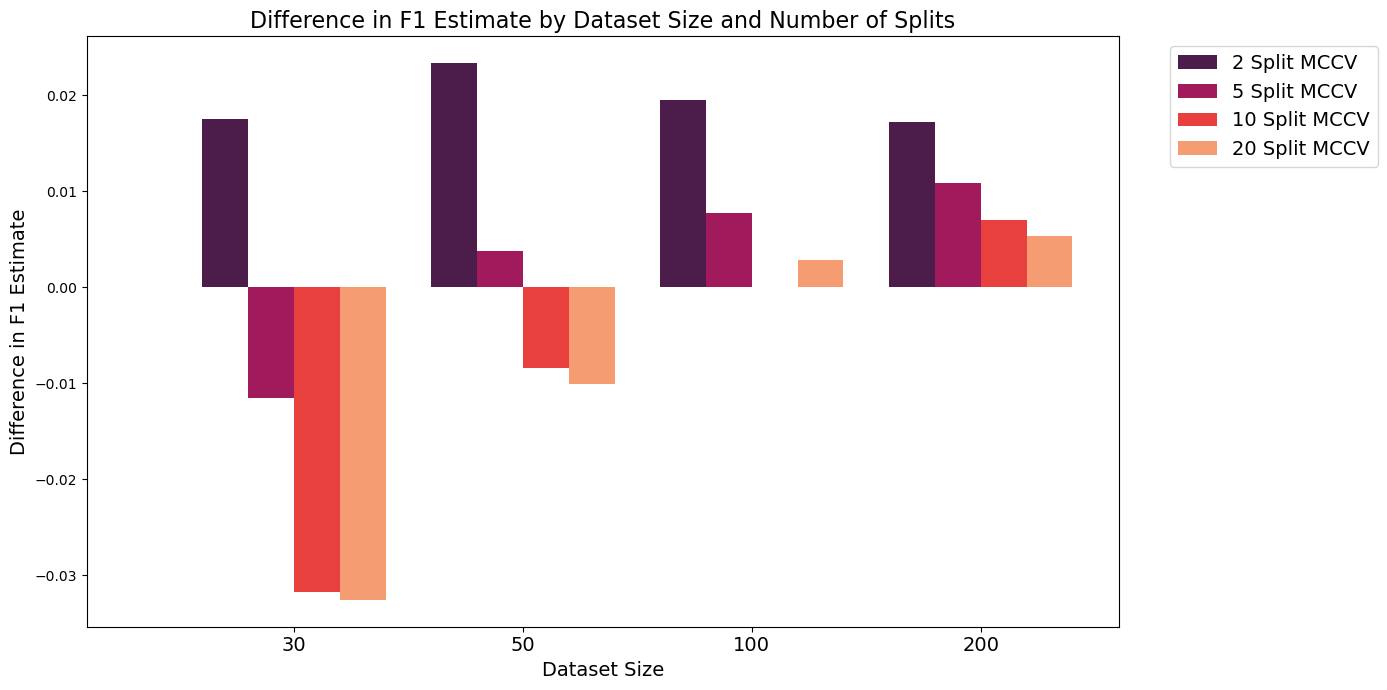

In [543]:
barChartDifference(df4, 'Logistic Regression', 'num splits', 'Split MCCV', 'Splits')

## Cross Validation for Linear SVC

In [234]:
def doCrossValidation(param_grid, num_train, algorithm_type): 

    sample_f1 = []
    sample_recall = []
    sample_precision = []
    population_f1 = []
    population_recall = []
    population_precision = []
    difference_in_f1 = []
    difference_in_recall = []
    difference_in_precision = []
    C_List = []
    
    for j in range(num_train):
        
        X_tiny,_,y_tiny,_ = train_test_split(X_forexperiments, y_forexperiments, train_size=tiny_size)
        X_trainval,X_test,y_trainval,y_test = train_test_split(X_tiny, y_tiny, train_size=0.8)
        X_train,X_val,y_train,y_val = train_test_split(X_trainval, y_trainval, train_size=0.75)
        
        best_val_f1 = -1
        best_val_recall = -1
        best_val_precision = -1
        best_model = None
        
        
        for params in ParameterGrid(param_grid):
            clf = None
            # Fit the model on the training data
            # Make predictions on the test data
            if algorithm_type == "Logistic Regression":
                clf = LogisticRegression(C=params['C'])
                clf.fit(X_train, y_train)
                predictions = clf.predict(X_val)

            else:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=ConvergenceWarning)
                    clf = LinearSVC(C=params['C'], max_iter=1000)
                    clf.fit(X_train, y_train)
                    predictions = clf.predict(X_val)

            # Calculate the F1 score
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="F-score is", category=Warning)
                val_f1 = f1_score(y_val, predictions, zero_division=0)


            predictions = clf.predict(X_val)
            val_f1 = f1_score(y_val, predictions)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_params = params
 

        
        C_List.append(best_params['C'])
        
        # Train a new model with the best params and make predictions
        if algorithm_type == "Logistic Regression":
            best_model = LogisticRegression(C=best_params['C'])
            best_model.fit(X_trainval,y_trainval)
            predictions = best_model.predict(X_test)
            
        else:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                best_model = LinearSVC(C=best_params['C'], max_iter=1000)
                best_model.fit(X_trainval,y_trainval)
                predictions = best_model.predict(X_test)
                
                
        # Calculate scores on hold out test data
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="F-score is", category=Warning)
            best_val_f1 = f1_score(y_test, predictions,zero_division=0)


        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Precision is", category=Warning)
            best_val_precision = precision_score(y_test,predictions,zero_division=0)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Recall is", category=Warning)
            best_val_recall = recall_score(y_test,predictions,zero_division=0)
            
        sample_f1.append(best_val_f1)
        sample_recall.append(best_val_recall)
        sample_precision.append(best_val_precision)
        
        # Run predictions on population data
        predictions = best_model.predict(X_population)
        
        
        #calculate scores on population data
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="F-score is", category=Warning)
            pop_f1 = f1_score(y_population, predictions, zero_division=0)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Recall is", category=Warning)
            pop_recall = recall_score(y_population, predictions, zero_division=0)
            
            
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Precision is", category=Warning)    
            pop_precision = precision_score(y_population, predictions, zero_division=0)


        population_f1.append(pop_f1)
        population_recall.append(pop_recall)
        population_precision.append(pop_precision)
        
        difference_in_f1.append(best_val_f1 - pop_f1)
        difference_in_recall.append(best_val_recall - pop_recall)
        difference_in_precision.append(best_val_precision - pop_precision)
        

    t_statistic, p_value = ttest_rel(sample_f1, population_f1)
        
    return np.mean(population_f1), np.mean(difference_in_f1), difference_in_f1, p_value, np.mean(population_recall), \
            np.mean(difference_in_recall), np.mean(population_precision), np.mean(difference_in_precision), C_List


In [235]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df5 = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    

    tic = time.perf_counter()

    average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doCrossValidation(param_grid, num_train = 1000, algorithm_type = "Linear SVC")
    # Create a new row of data as a dictionary
    toc = time.perf_counter()
    run_time = toc-tic
    new_row_data = {
        'average model f1': average_model_f1,
        'average difference in f1 estimate': f1_diff,
        'differences in f1 estimate':all_f1_diff,
        'f1 p-value': f1_p_value,
        'average model recall': average_model_recall,
        'difference in recall estimate': recall_diff,
        'average model precision': average_model_precision,
        'difference in precision estimate': precision_diff,
        'dataset size': tiny_size,
        'best parameter': C_List,
        'time': run_time

    }

    # Add the new row to the DataFrame using the loc attribute
    df5.loc[len(df5)] = new_row_data
df5
    
    

Current Loop:  30


/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-sco

Current Loop:  50
Current Loop:  100
Current Loop:  200


,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,30,0.783527,-0.025426,"[0.20989407542141247, 0.05389433971713187, 0.1...",0.000863,0.777031,-0.004531,0.794008,0.006092,"[0.01, 0.01, 1, 0.01, 0.01, 1, 0.01, 0.05, 0.1...",93.683349
1,50,0.802059,-0.013181,"[-0.1367462888803923, -0.030533983504906104, -...",0.009345,0.794162,0.008152,0.812905,-0.000140,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",93.401488
2,100,0.826811,-0.000032,"[-0.06012042413083363, -0.02575245263787207, 0...",0.991256,0.814060,0.011806,0.841636,0.003013,"[0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",97.128274
3,200,0.844921,0.007808,"[0.0037492879346132657, 0.026824792509254958, ...",0.000071,0.830162,0.017436,0.860961,0.004190,"[0.01, 0.01, 0.01, 0.05, 0.01, 0.01, 0.01, 0.0...",99.676946


## Cross Validation for Logistic Regression

In [236]:
param_grid = {'C': [0.01,0.05,0.1,1,5]}
columns = ['dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value','average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate','best parameter','time']
df6 = pd.DataFrame(columns=columns)

for tiny_size in tiny_dataset_size:
    print('Current Loop: ', tiny_size)
    

    tic = time.perf_counter()

    average_model_f1, f1_diff, all_f1_diff, f1_p_value, average_model_recall, recall_diff, average_model_precision, precision_diff, C_List = doCrossValidation(param_grid, num_train = 1000, algorithm_type = "Logistic Regression")
    # Create a new row of data as a dictionary
    toc = time.perf_counter()
    run_time = toc-tic
    new_row_data = {
        'average model f1': average_model_f1,
        'average difference in f1 estimate': f1_diff,
        'differences in f1 estimate':all_f1_diff,
        'f1 p-value': f1_p_value,
        'average model recall': average_model_recall,
        'difference in recall estimate': recall_diff,
        'average model precision': average_model_precision,
        'difference in precision estimate': precision_diff,
        'dataset size': tiny_size,
        'best parameter': C_List,
        'time': run_time

    }

    # Add the new row to the DataFrame using the loc attribute
    df6.loc[len(df6)] = new_row_data
df6
    
    

Current Loop:  30


/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-sco

/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/ashwinkrishnamurthi/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-sco

Current Loop:  50
Current Loop:  100
Current Loop:  200


,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,30,0.675614,-0.032433,"[0.07146393136576268, -0.015019210618232637, -...",0.000016,0.734544,-0.067094,0.712422,-0.004289,"[0.05, 0.01, 0.01, 1, 1, 5, 0.01, 0.05, 1, 0.0...",91.809387
1,50,0.768868,-0.007978,"[0.07347748270691246, -0.22340926528560467, -0...",0.141401,0.783957,0.001241,0.793548,0.004409,"[0.05, 0.01, 1, 5, 0.01, 5, 0.1, 0.1, 1, 0.1, ...",97.247440
2,100,0.818369,0.000459,"[0.06789659608413245, 0.017068704954580904, 0....",0.883802,0.811629,0.011892,0.835737,0.004391,"[0.01, 0.01, 1, 0.05, 0.05, 1, 0.1, 0.01, 1, 0...",95.675404
3,200,0.843936,0.003475,"[0.10305407448264581, 0.03833599600838611, -0....",0.076372,0.831033,0.013982,0.860455,-0.000191,"[0.05, 5, 0.01, 0.01, 0.05, 0.01, 0.05, 0.05, ...",96.216881


# Evaluation

In [255]:
df_eval = df.copy()
df2_eval = df2.copy()
df3_eval = df3.copy()
df4_eval = df4.copy()
df5_eval = df5.copy()
df6_eval = df6.copy()

In [256]:
df_eval.rename(columns={'num k folds': 'num k folds/splits'}, inplace=True)
df2_eval.rename(columns={'num k folds': 'num k folds/splits'}, inplace=True)
df3_eval.rename(columns={'num splits': 'num k folds/splits'}, inplace=True)
df4_eval.rename(columns={'num splits': 'num k folds/splits'}, inplace=True)

In [260]:
df5_eval.insert(1, 'num k folds/splits', 'N/A')
df6_eval.insert(1, 'num k folds/splits', 'N/A')

In [265]:
df_eval.insert(1, 'CV Type', 'K-Fold')
df2_eval.insert(1, 'CV Type', 'K-Fold')
df3_eval.insert(1, 'CV Type', 'MCCV')
df4_eval.insert(1, 'CV Type', 'MCCV')
df5_eval.insert(1, 'CV Type', 'CV')
df6_eval.insert(1, 'CV Type', 'CV')

In [268]:
rows_to_change = [4, 9, 14, 19]
new_value = 'LOO'

df_eval.loc[rows_to_change, 'CV Type'] = new_value
df2_eval.loc[rows_to_change, 'CV Type'] = new_value

In [393]:
df_list = [df_eval, df2_eval, df3_eval, df4_eval, df5_eval, df6_eval]

# Concatenate DataFrames vertically (along rows)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
combined_df

,Algorithm type,CV Type,num k folds/splits,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time
0,Linear SVC,K-Fold,2,30,0.784187,-0.011523,"[0.005562355057332602, -0.11242884250474372, -...",9.719099e-04,0.778734,0.002074,0.793178,-0.000470,"[0.01, 1, 0.01, 1, 0.01, 0.01, 1, 1, 0.01, 0.0...",100.271550
1,Linear SVC,K-Fold,5,30,0.787542,-0.015855,"[0.010271830899906242, -0.020506006070497906, ...",2.598156e-05,0.779866,0.011914,0.798999,0.007371,"[0.01, 0.05, 1, 0.05, 0.01, 0.01, 0.1, 0.1, 0....",119.345806
2,Linear SVC,K-Fold,10,30,0.786271,-0.087005,"[-0.03152713504417326, -0.11725677705410498, 0...",1.206102e-84,0.778739,-0.061922,0.797504,-0.073187,"[0.01, 0.01, 0.1, 0.01, 0.01, 0.05, 1, 0.05, 0...",156.037080
3,Linear SVC,K-Fold,20,30,0.787024,-0.285874,"[-0.21407847341741193, -0.29843486218267307, -...",0.000000e+00,0.781179,-0.275229,0.796569,-0.287744,"[0.05, 5, 0.01, 0.01, 0.01, 0.05, 0.01, 0.05, ...",230.579851
4,Linear SVC,LOO,30,30,0.789468,-0.382301,"[-0.4608215103894538, -0.39982016849430213, -0...",0.000000e+00,0.782841,-0.375675,0.799563,-0.392396,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.0...",300.074445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Linear SVC,CV,N/A,200,0.844921,0.007808,"[0.0037492879346132657, 0.026824792509254958, ...",7.109193e-05,0.830162,0.017436,0.860961,0.004190,"[0.01, 0.01, 0.01, 0.05, 0.01, 0.01, 0.01, 0.0...",99.676946
76,Logistic Regression,CV,N/A,30,0.675614,-0.032433,"[0.07146393136576268, -0.015019210618232637, -...",1.597650e-05,0.734544,-0.067094,0.712422,-0.004289,"[0.05, 0.01, 0.01, 1, 1, 5, 0.01, 0.05, 1, 0.0...",91.809387
77,Logistic Regression,CV,N/A,50,0.768868,-0.007978,"[0.07347748270691246, -0.22340926528560467, -0...",1.414012e-01,0.783957,0.001241,0.793548,0.004409,"[0.05, 0.01, 1, 5, 0.01, 5, 0.1, 0.1, 1, 0.1, ...",97.247440
78,Logistic Regression,CV,N/A,100,0.818369,0.000459,"[0.06789659608413245, 0.017068704954580904, 0....",8.838015e-01,0.811629,0.011892,0.835737,0.004391,"[0.01, 0.01, 1, 0.05, 0.05, 1, 0.1, 0.01, 1, 0...",95.675404


In [270]:
column_names = combined_df.columns.tolist()

# Display the list of column names
print(column_names)

['Algorithm type', 'CV Type', 'num k folds/splits', 'dataset size', 'average model f1', 'average difference in f1 estimate', 'differences in f1 estimate', 'f1 p-value', 'average model precision', 'difference in precision estimate', 'average model recall', 'difference in recall estimate', 'best parameter', 'time']


In [545]:
combined_df2 = combined_df.copy()
combined_df2

,Algorithm type,CV Type,num k folds/splits,dataset size,average model f1,average difference in f1 estimate,differences in f1 estimate,f1 p-value,average model precision,difference in precision estimate,average model recall,difference in recall estimate,best parameter,time,CV Technique
72,Linear SVC,CV,N/A,30,0.783527,-0.025426,"[0.20989407542141247, 0.05389433971713187, 0.1...",8.627991e-04,0.777031,-0.004531,0.794008,0.006092,"[0.01, 0.01, 1, 0.01, 0.01, 1, 0.01, 0.05, 0.1...",93.683349,CV - N/A folds
73,Linear SVC,CV,N/A,50,0.802059,-0.013181,"[-0.1367462888803923, -0.030533983504906104, -...",9.345140e-03,0.794162,0.008152,0.812905,-0.000140,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",93.401488,CV - N/A folds
74,Linear SVC,CV,N/A,100,0.826811,-0.000032,"[-0.06012042413083363, -0.02575245263787207, 0...",9.912560e-01,0.814060,0.011806,0.841636,0.003013,"[0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",97.128274,CV - N/A folds
75,Linear SVC,CV,N/A,200,0.844921,0.007808,"[0.0037492879346132657, 0.026824792509254958, ...",7.109193e-05,0.830162,0.017436,0.860961,0.004190,"[0.01, 0.01, 0.01, 0.05, 0.01, 0.01, 0.01, 0.0...",99.676946,CV - N/A folds
76,Logistic Regression,CV,N/A,30,0.675614,-0.032433,"[0.07146393136576268, -0.015019210618232637, -...",1.597650e-05,0.734544,-0.067094,0.712422,-0.004289,"[0.05, 0.01, 0.01, 1, 1, 5, 0.01, 0.05, 1, 0.0...",91.809387,CV - N/A folds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,Linear SVC,MCCV,20,200,0.849377,0.003974,"[0.024463280389701803, -0.016455148821711285, ...",1.433828e-05,0.834124,0.012798,0.865765,0.001331,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.01...",370.107207,MCCV - 20 folds
59,Logistic Regression,MCCV,20,30,0.772993,-0.032566,"[-0.0029992611020742688, -0.006108273052521929...",1.499849e-18,0.768538,-0.005364,0.795950,-0.005819,"[5, 1, 0.1, 1, 5, 1, 0.1, 0.1, 0.05, 0.05, 0.1...",303.232269,MCCV - 20 folds
63,Logistic Regression,MCCV,20,50,0.803175,-0.010062,"[0.041767861897944014, -0.0314193253384748, 0....",1.935028e-05,0.793453,0.011115,0.822580,0.007274,"[0.05, 0.1, 0.05, 1, 0.05, 5, 0.05, 0.1, 0.1, ...",311.956932,MCCV - 20 folds
67,Logistic Regression,MCCV,20,100,0.834616,0.002802,"[-0.004373462185675581, 0.052643469078450855, ...",5.073507e-02,0.819030,0.015572,0.854780,0.005202,"[0.05, 5, 0.1, 0.1, 0.1, 0.1, 1, 0.05, 0.05, 5...",313.803403,MCCV - 20 folds


In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_individual_f1_colored_bar_plot(dataframe, y_low, y_high, y_ticks, metric, dataset_size_filter=None, algorithm_type_filter=None):
    filtered_df = dataframe.copy()
    
    # Convert 'average model f1' column to float
    filtered_df[metric] = filtered_df[metric].astype(float)
    
    # Apply filters if provided
    if dataset_size_filter:
        filtered_df = filtered_df[filtered_df['dataset size'] == dataset_size_filter]
    if algorithm_type_filter:
        filtered_df = filtered_df[filtered_df['Algorithm type'] == algorithm_type_filter]
    
    # Create the bar plot with colored bars based on 'CV Type'
    plt.figure(figsize=(12, 6))
    
    # Group the data by 'num k folds/splits' and 'CV Type' and aggregate the mean of 'average model f1'
    grouped_df = filtered_df.groupby(['num k folds/splits', 'CV Type'])[metric].mean().unstack()
    x_values = range(len(grouped_df))
    
    # Get a list of unique 'CV Type' values
    unique_cv_types = filtered_df['CV Type'].unique()
    
    # Get a list of colors from the color palette
    cmap = sns.color_palette('viridis', len(unique_cv_types))
    
    bar_width = 0.2  # Width of each bar
    
    for i, cv_type in enumerate(unique_cv_types):
        bars = plt.bar([x + i * bar_width for x in x_values], grouped_df[cv_type], width=bar_width, label=cv_type)
        
        # Set individual bar colors based on 'CV Type'
        color = cmap[i]  # Get color from the color palette
        for bar in bars:
            bar.set_color(color)
    
    plt.xlabel('num k folds/splits')
    plt.ylabel(metric)
    plt.title(metric +  ' by num k folds/splits and CV Type')
    
    plt.xticks([x + bar_width * (len(unique_cv_types) - 1) / 2 for x in x_values], grouped_df.index)
    # Set y-axis limits and ticks
    plt.ylim(y_low, y_high)
    plt.yticks(y_ticks)
    
    
    # Create a legend for 'CV Type'
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Assuming you have a DataFrame named 'combined_df'
# Call the function with appropriate parameters


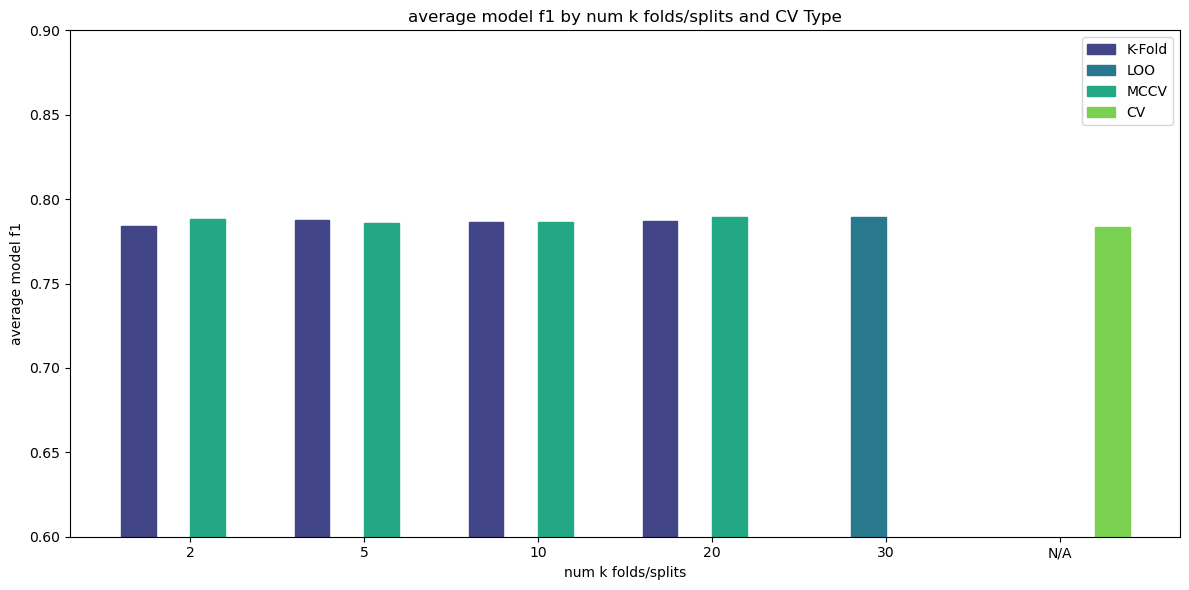

In [356]:
create_individual_f1_colored_bar_plot(combined_df, 0.6, 0.9, [0.6,0.65,0.7, 0.75, 0.8, 0.85, 0.9],  dataset_size_filter = 30, metric = 'average model f1', algorithm_type_filter='Linear SVC')


## Histogram for F1 Estimate Differences

In [567]:
# Group by specified columns and flatten the list of lists in the "differences in f1 estimate" column
# grouped = combined_df2.groupby(['Algorithm type', 'CV Type', 'num k folds/splits'])['differences in f1 estimate'].apply(lambda x: [item for sublist in x for item in sublist]).reset_index()
grouped = combined_df2.groupby(['CV Type', 'num k folds/splits'])['differences in f1 estimate'].apply(lambda x: [item for sublist in x for item in sublist]).reset_index()

# Display the resulting DataFrame
print(grouped)


   CV Type num k folds/splits  \
0       CV                N/A   
1   K-Fold                  2   
2   K-Fold                  5   
3   K-Fold                 10   
4   K-Fold                 20   
5      LOO                 30   
6      LOO                 50   
7      LOO                100   
8      LOO                200   
9     MCCV                  2   
10    MCCV                  5   
11    MCCV                 10   
12    MCCV                 20   

                           differences in f1 estimate  
0   [0.20989407542141247, 0.05389433971713187, 0.1...  
1   [0.005562355057332602, -0.11242884250474372, -...  
2   [0.010271830899906242, -0.020506006070497906, ...  
3   [-0.03152713504417326, -0.11725677705410498, 0...  
4   [-0.21407847341741193, -0.29843486218267307, -...  
5   [-0.4608215103894538, -0.39982016849430213, -0...  
6   [-0.3721655316506845, -0.4150355923375195, -0....  
7   [-0.42202137080110996, -0.4861976527992288, -0...  
8   [-0.399590891547665, -0.42030

In [570]:
grouped2 = combined_df2.groupby(['CV Type'])['differences in f1 estimate'].apply(lambda x: [item for sublist in x for item in sublist]).reset_index()
print(grouped2)

  CV Type                         differences in f1 estimate
0      CV  [0.20989407542141247, 0.05389433971713187, 0.1...
1  K-Fold  [0.005562355057332602, -0.11242884250474372, -...
2     LOO  [-0.4608215103894538, -0.39982016849430213, -0...
3    MCCV  [0.025109922424174536, -0.014997873834317277, ...


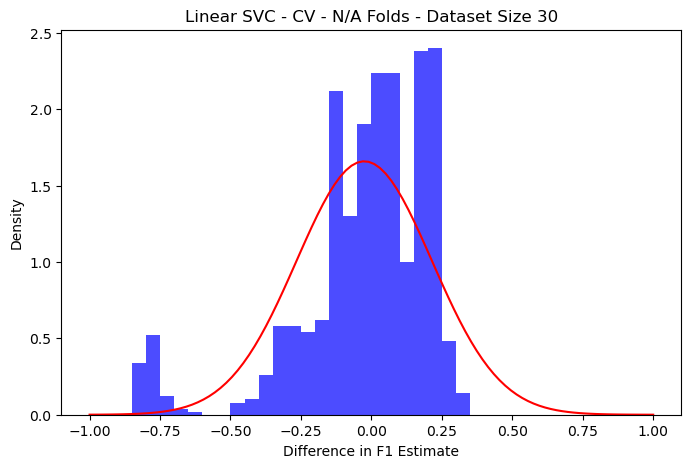

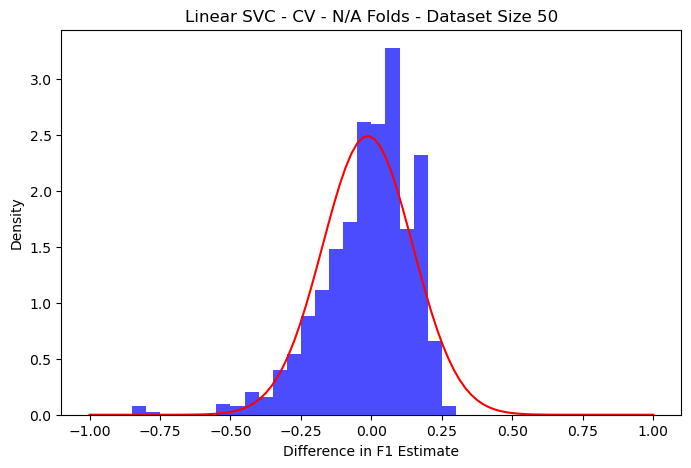

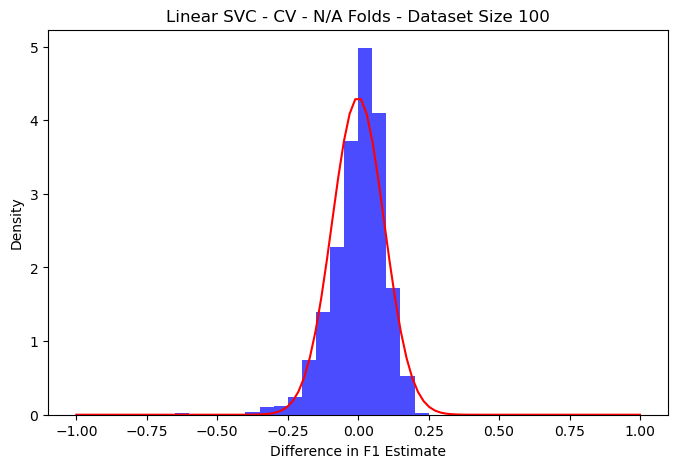

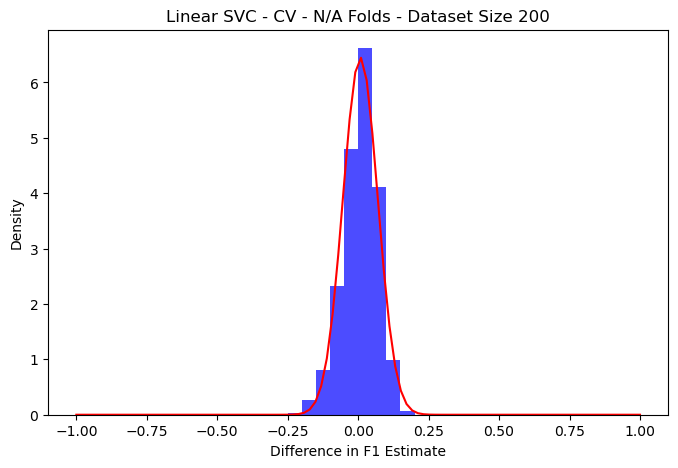

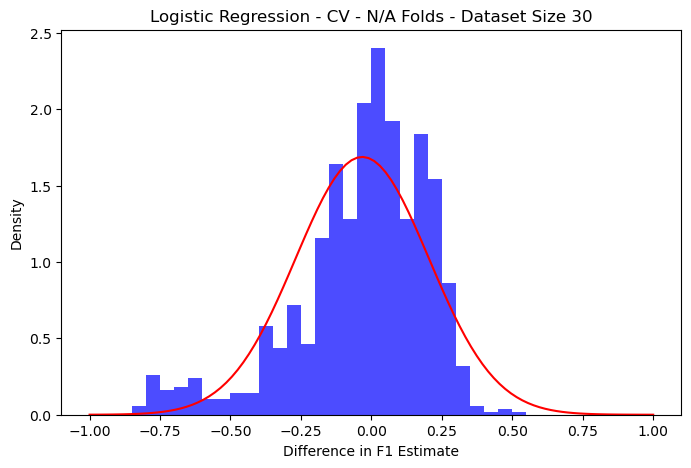

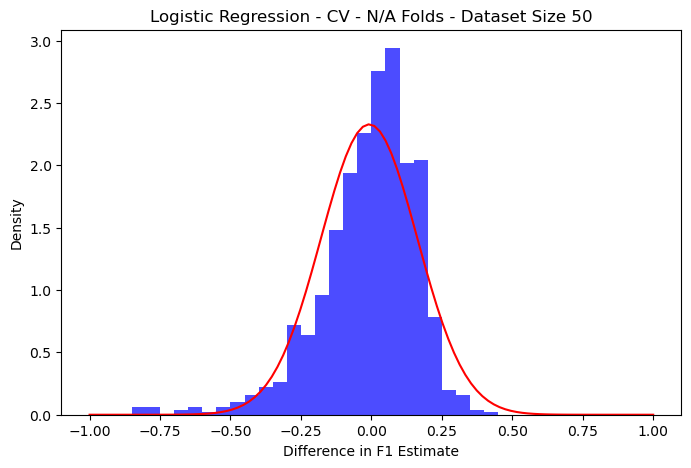

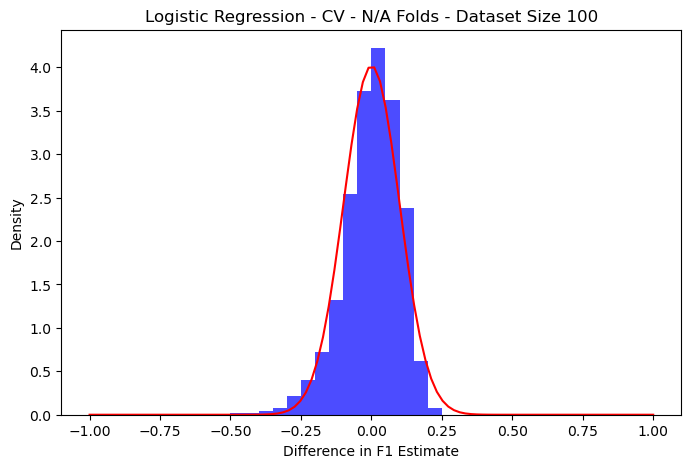

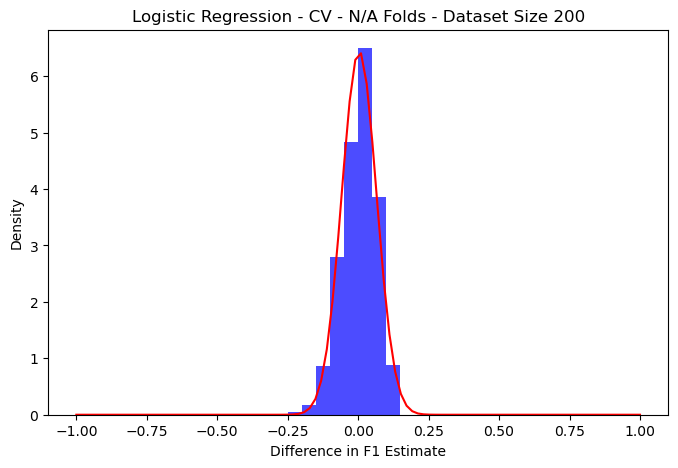

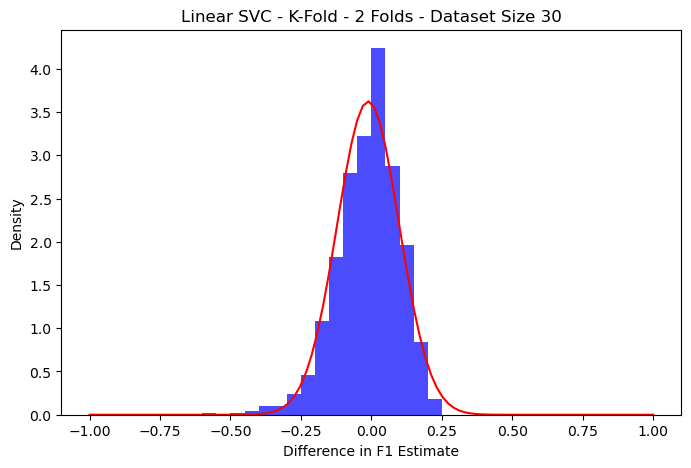

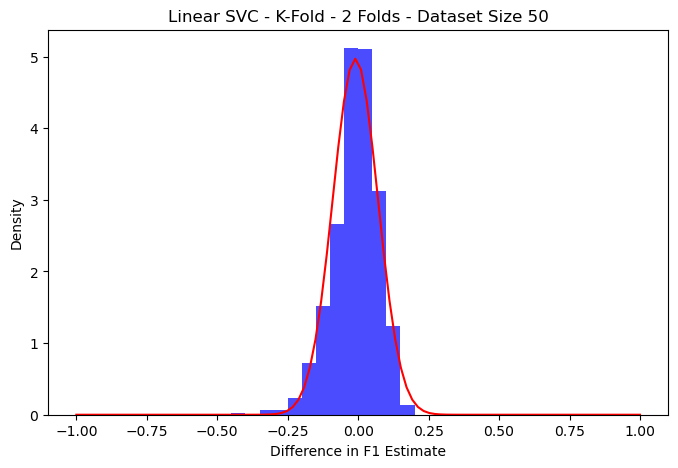

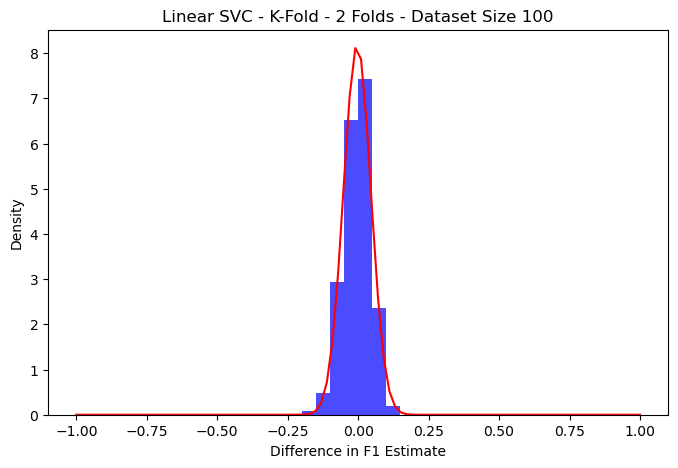

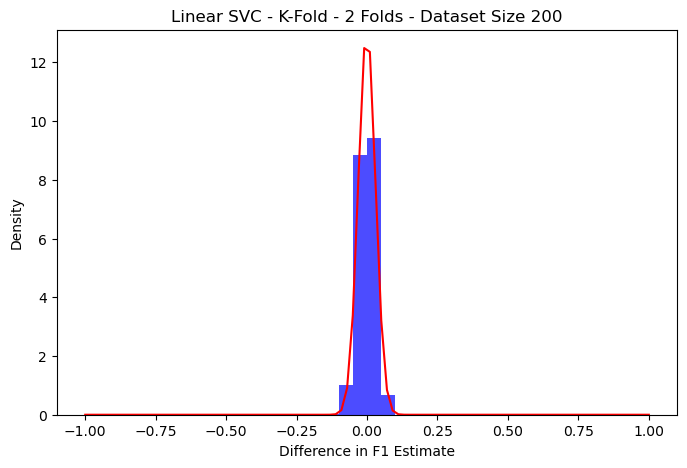

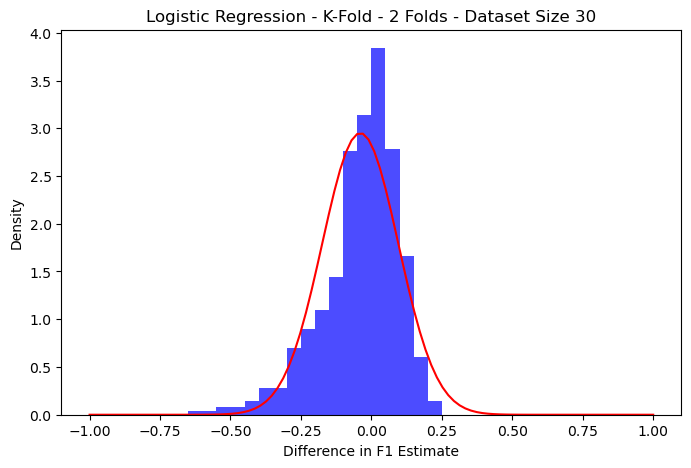

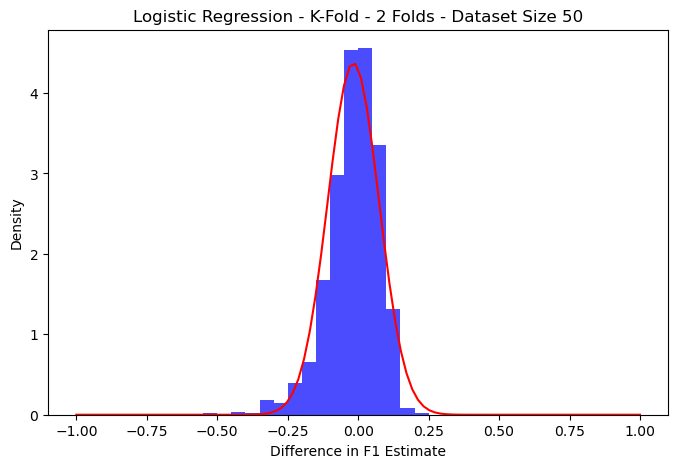

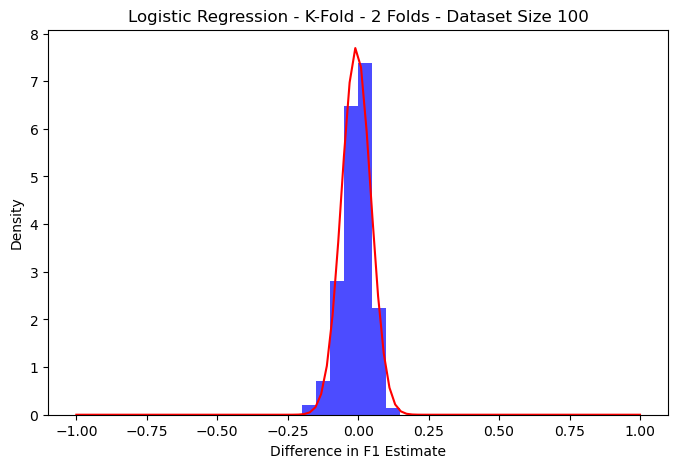

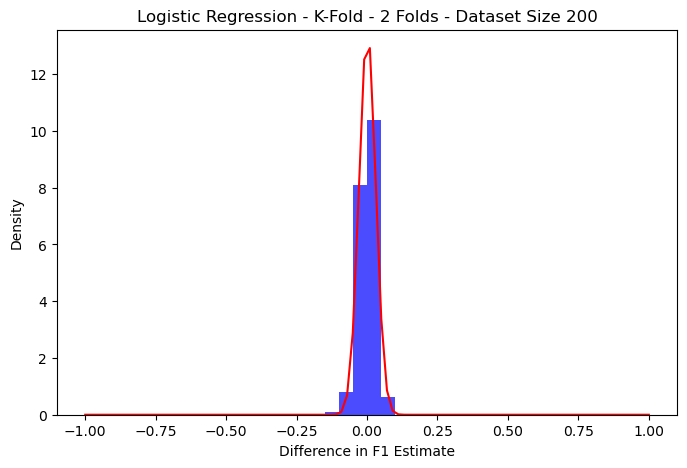

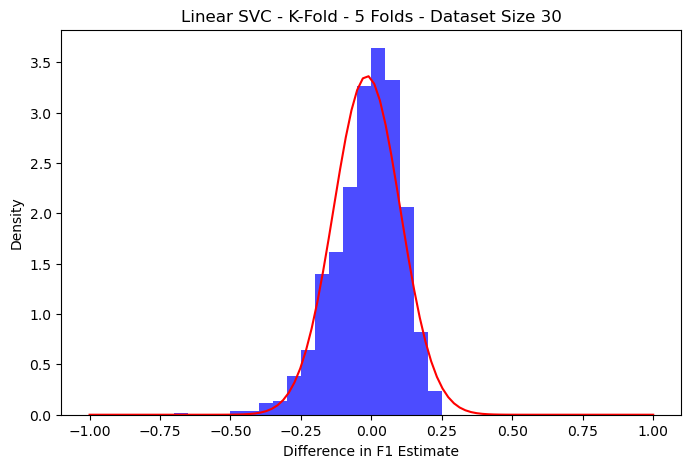

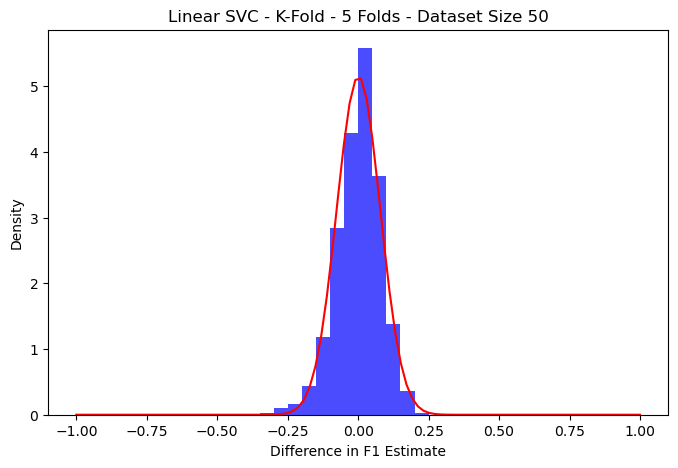

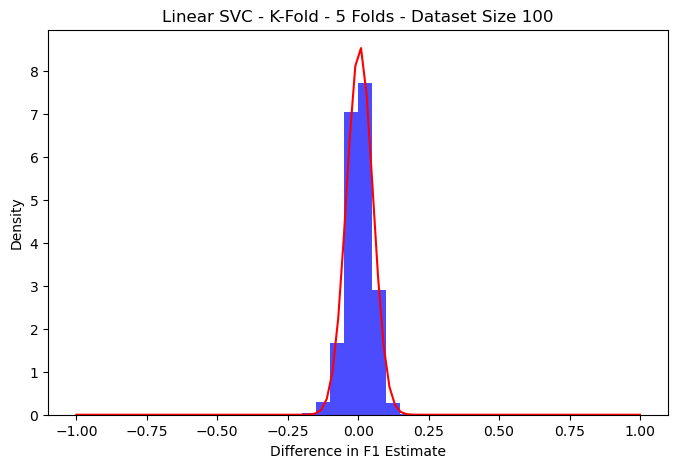

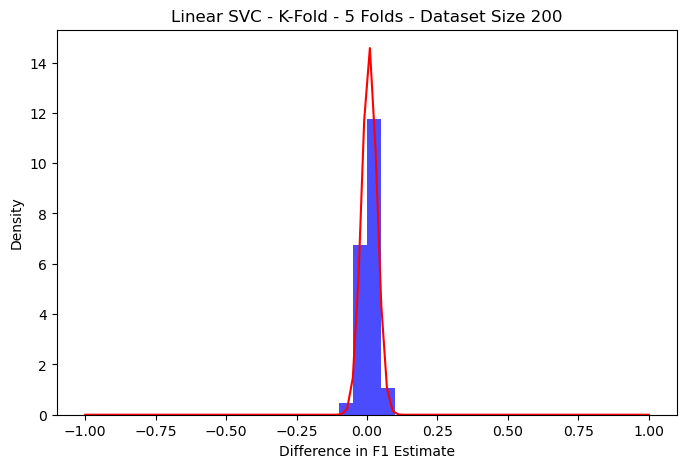

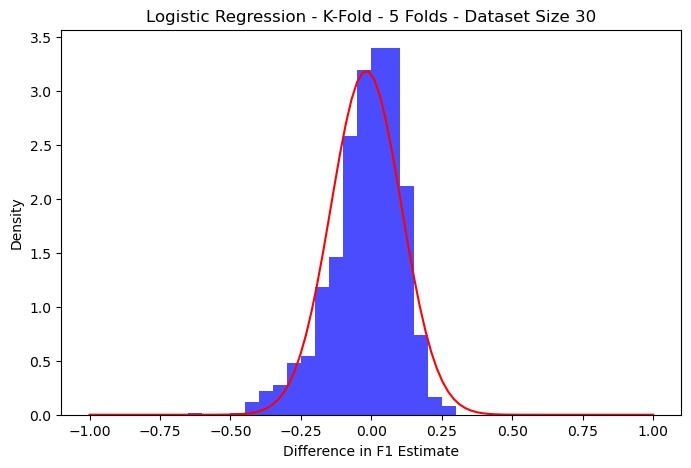

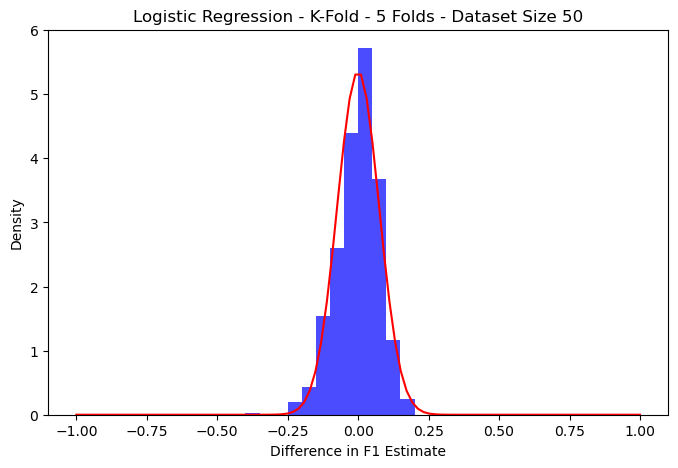

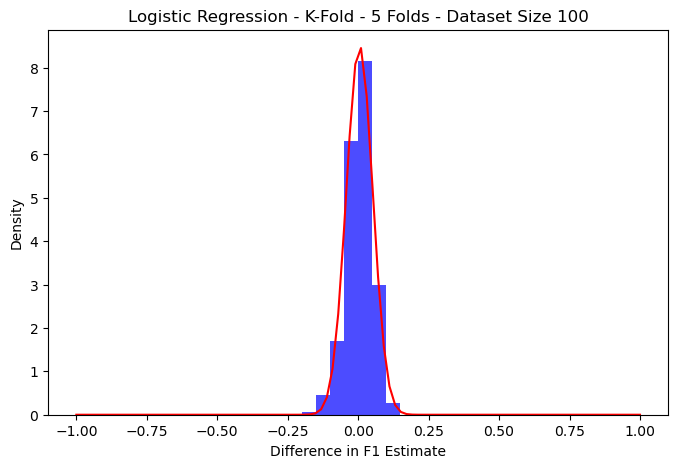

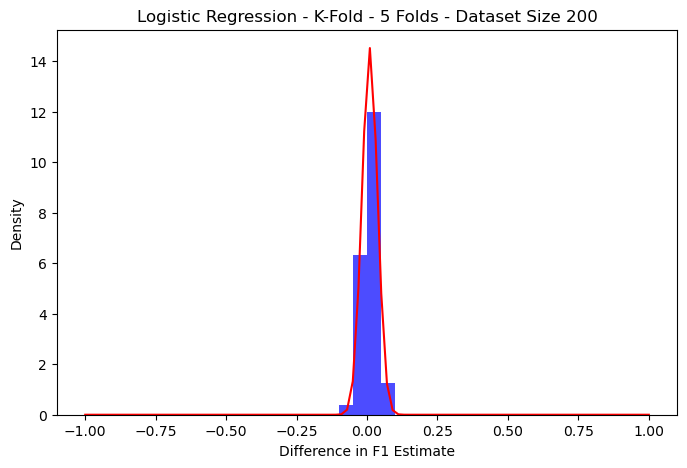

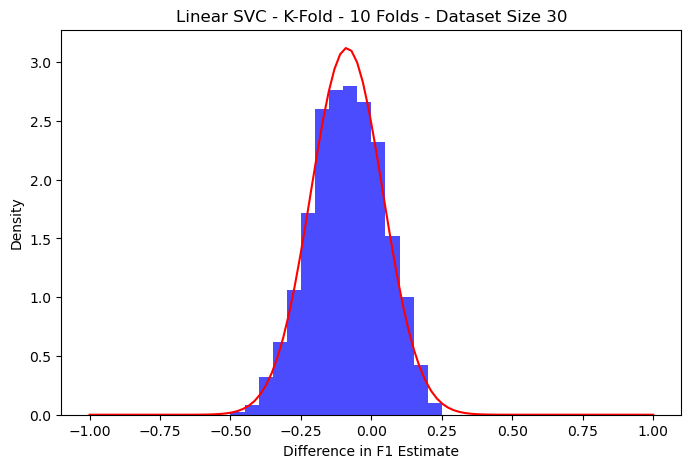

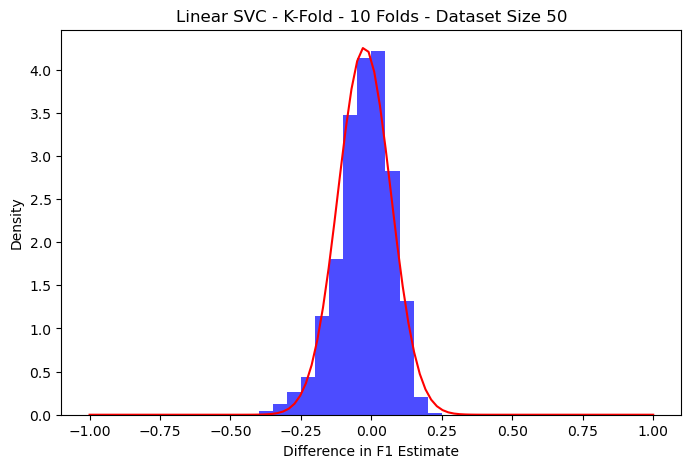

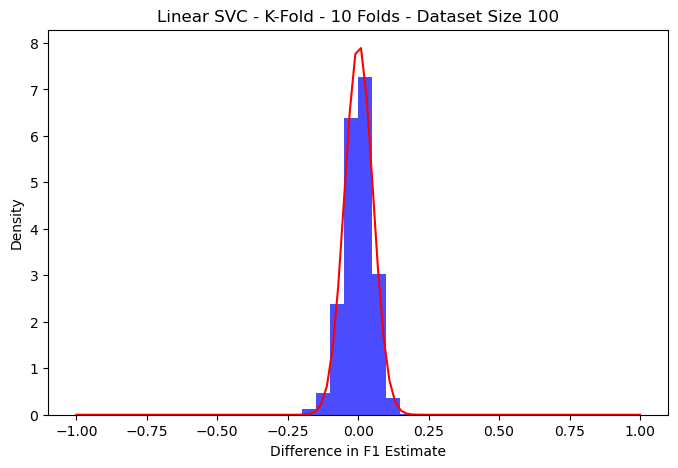

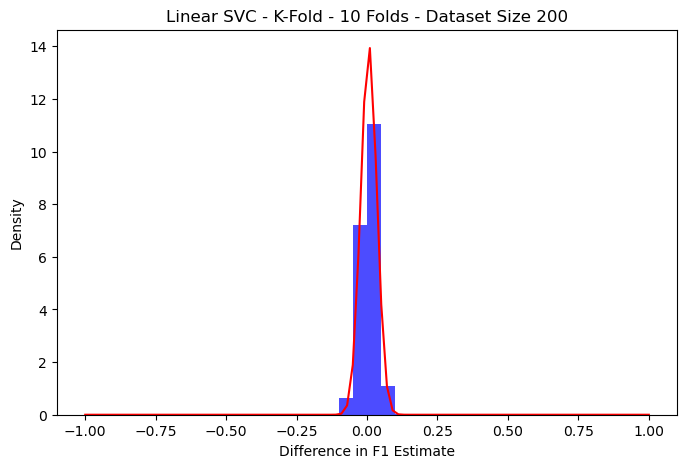

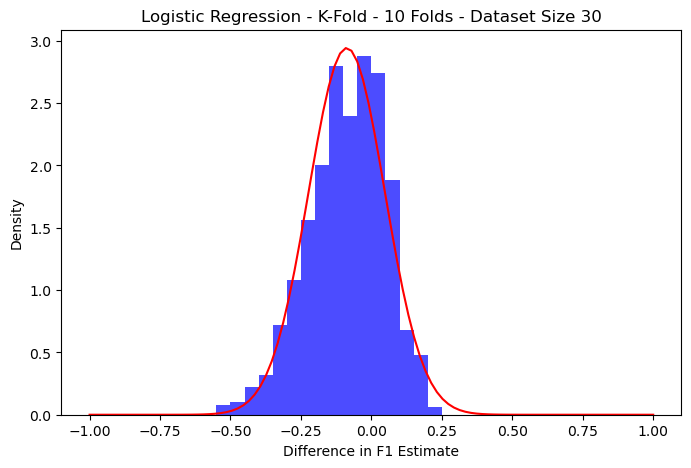

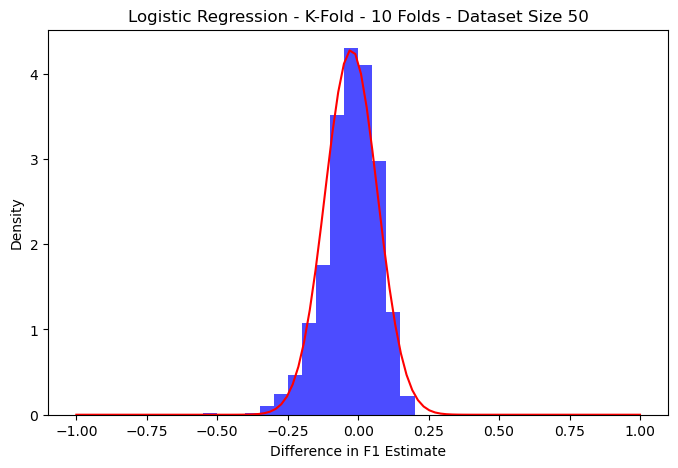

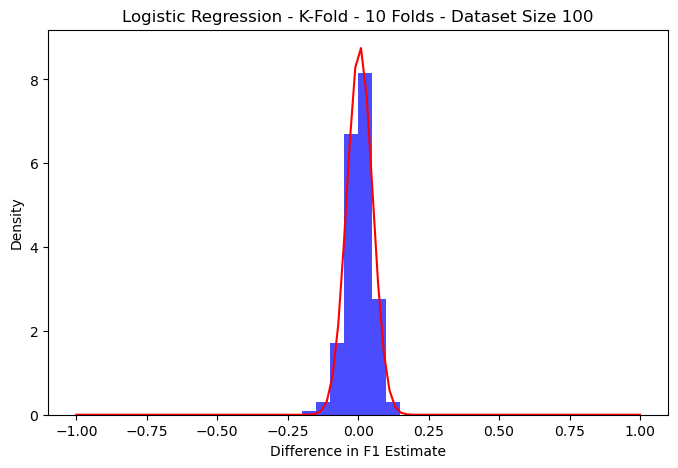

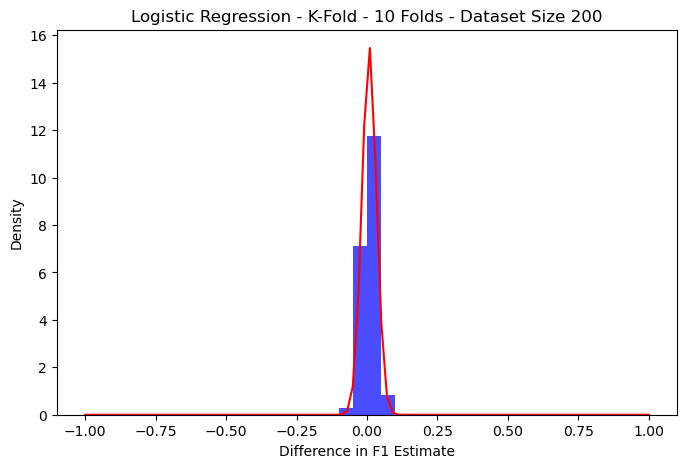

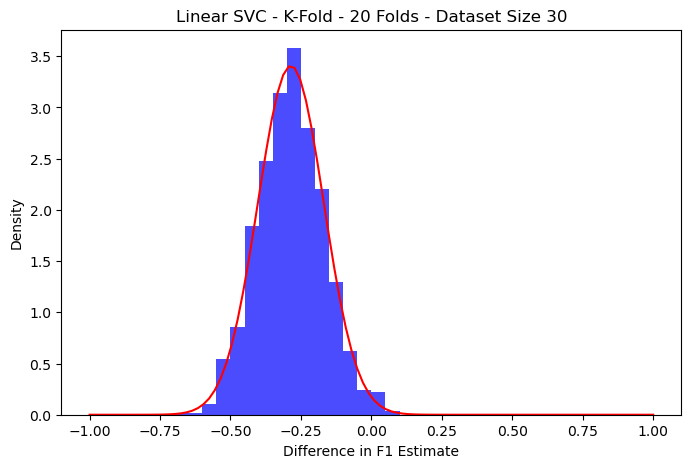

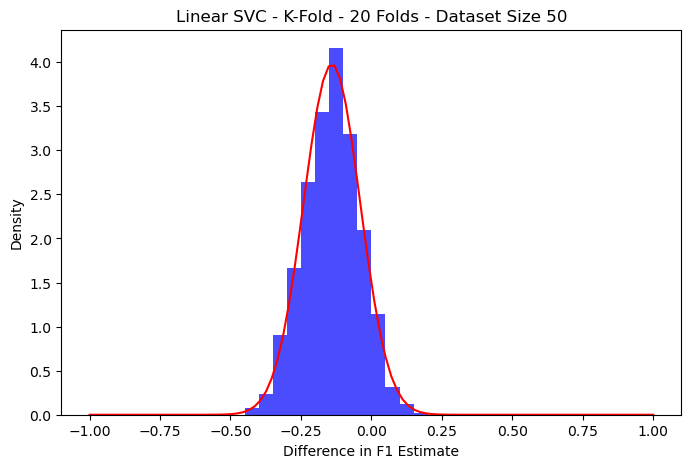

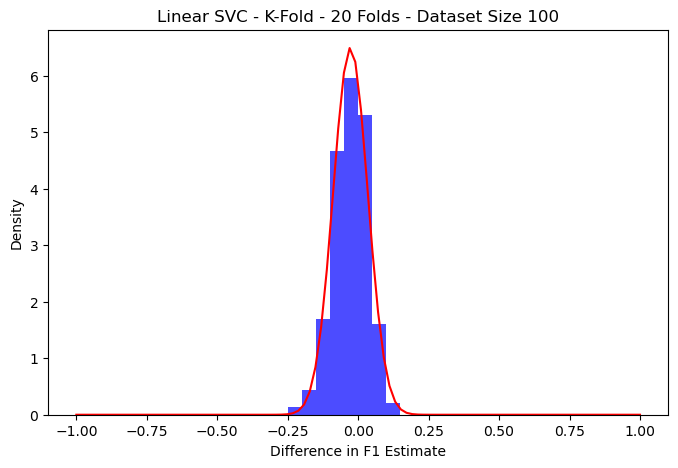

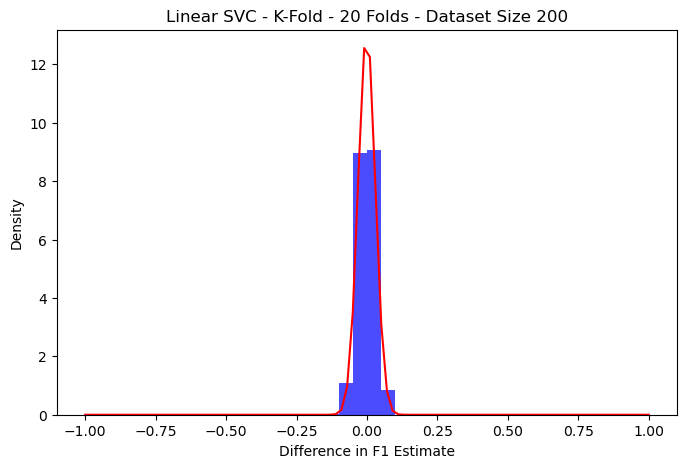

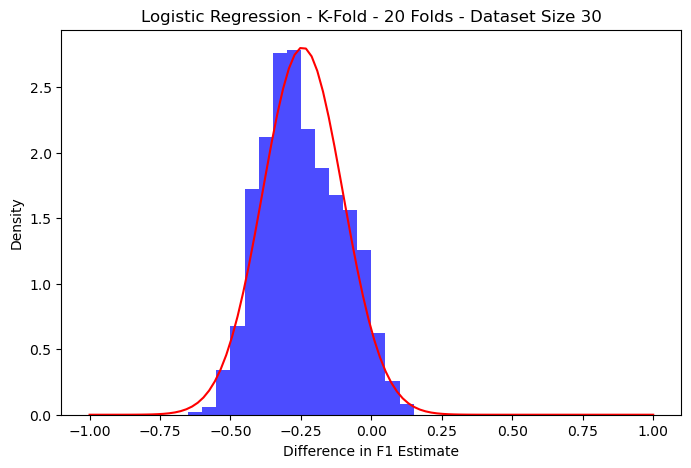

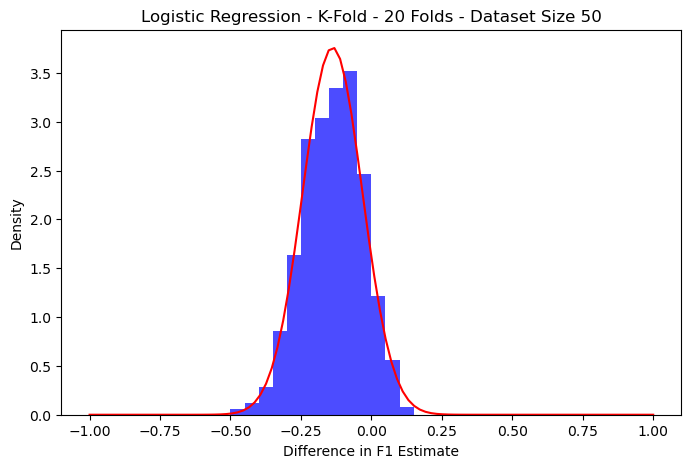

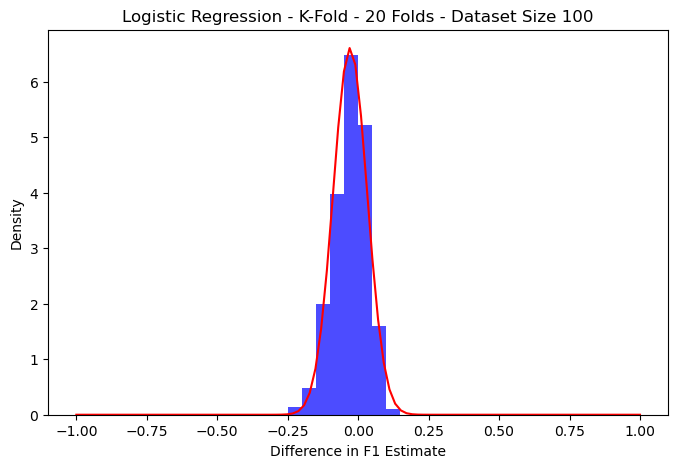

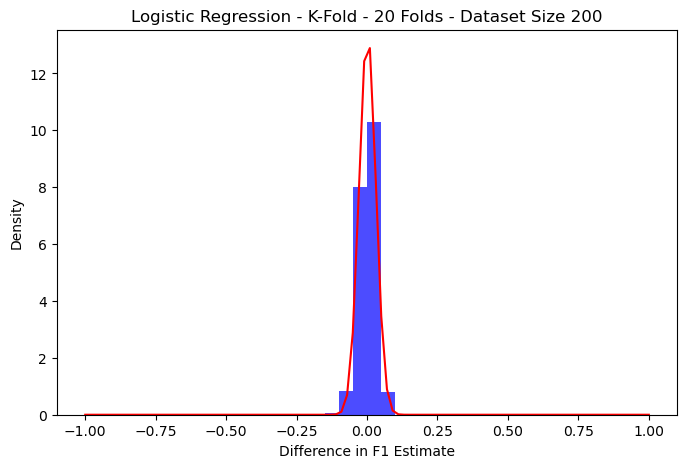

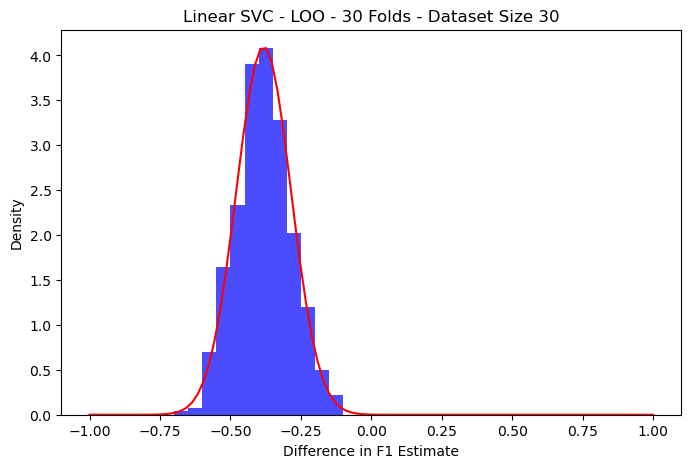

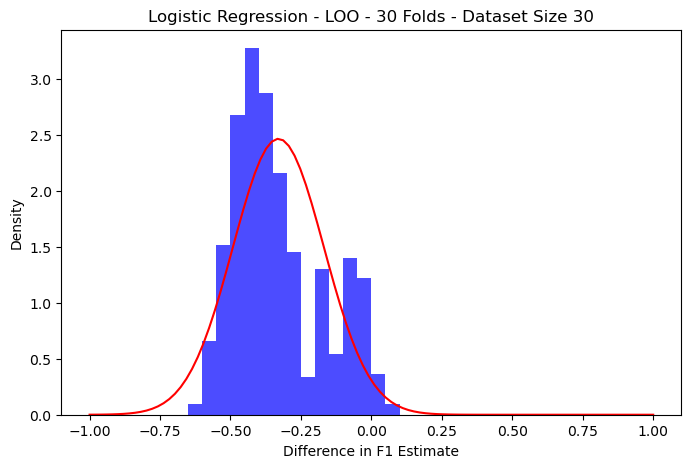

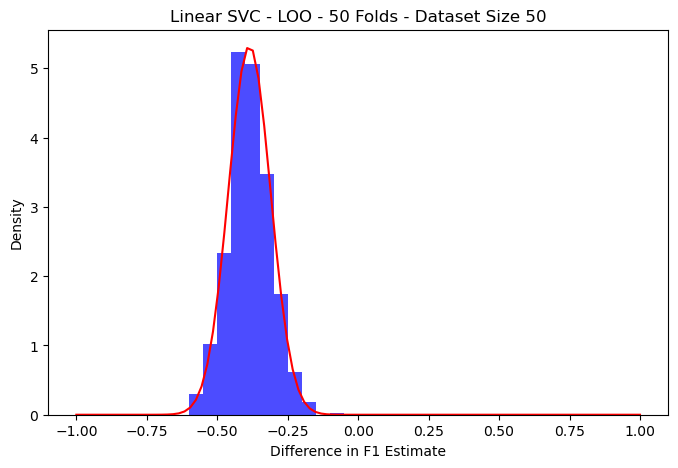

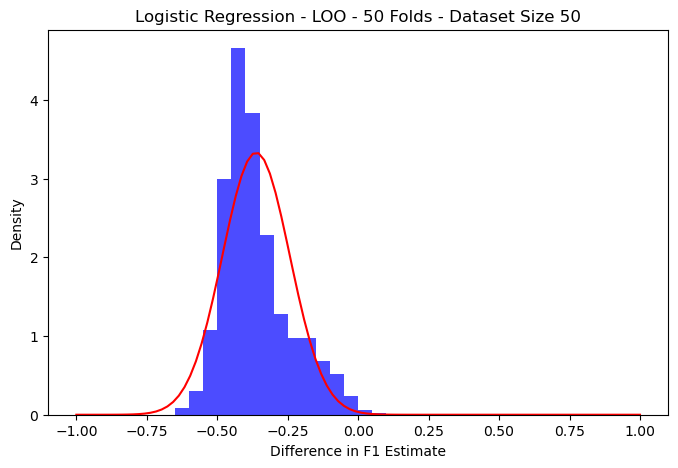

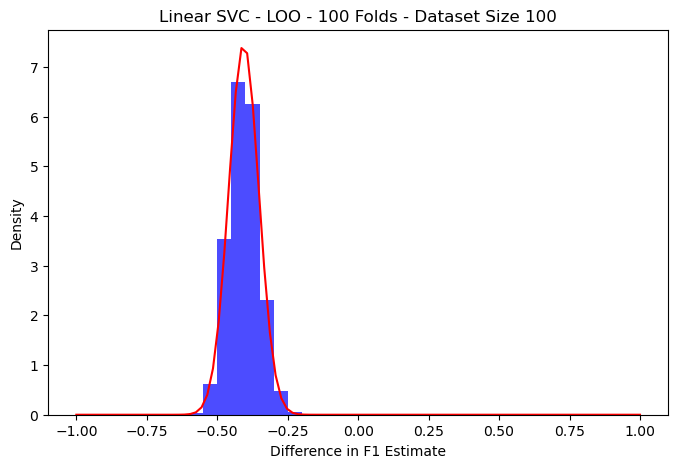

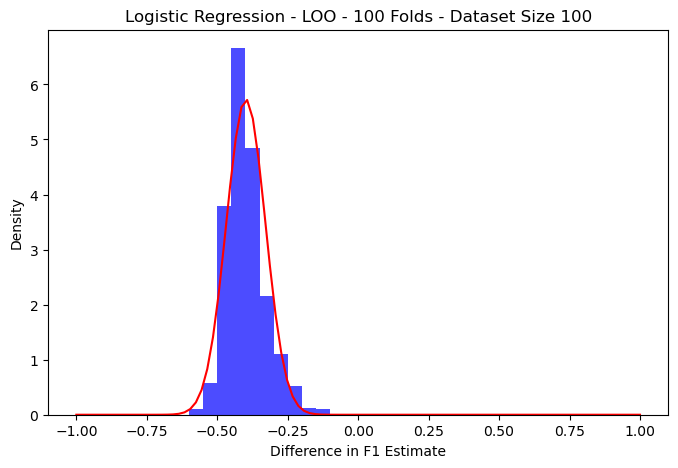

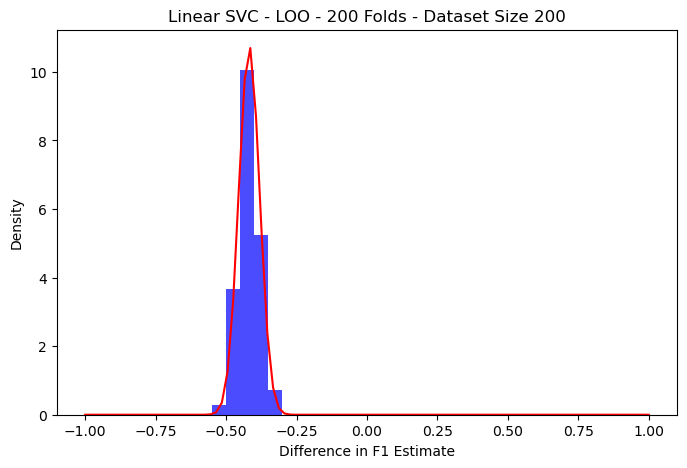

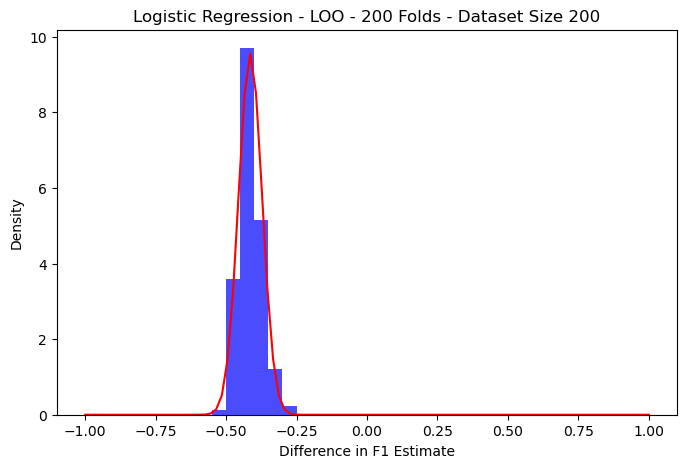

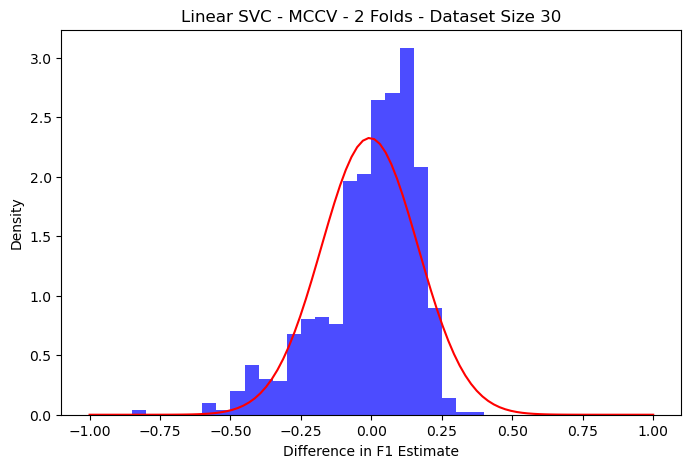

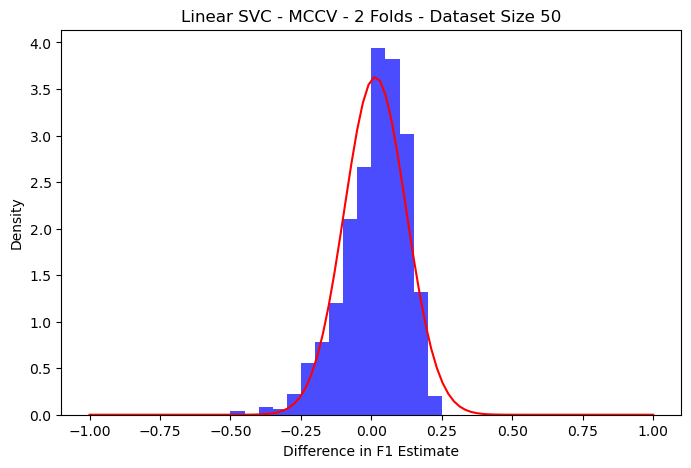

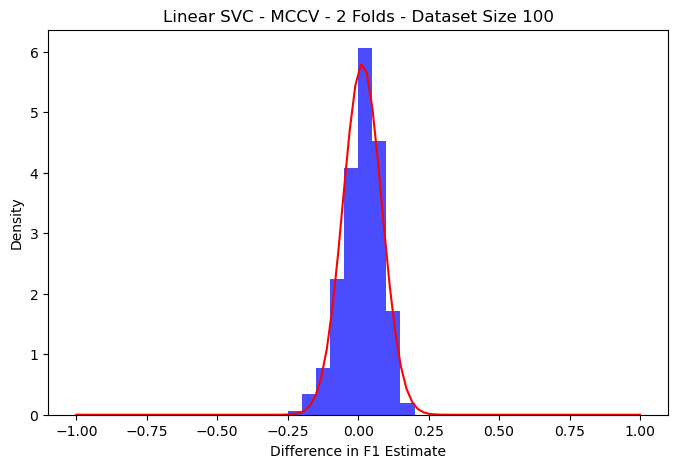

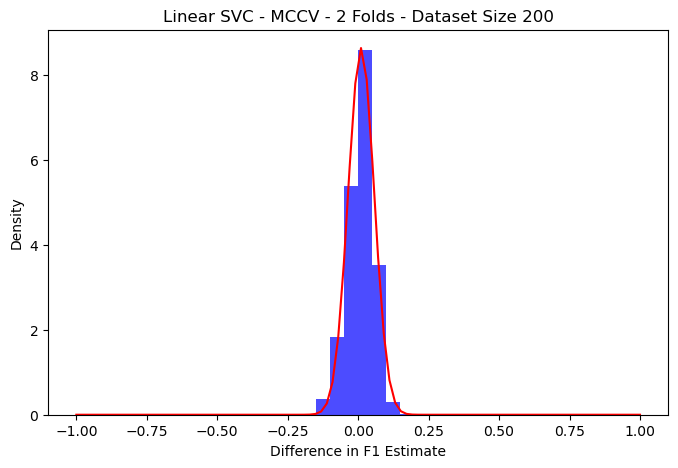

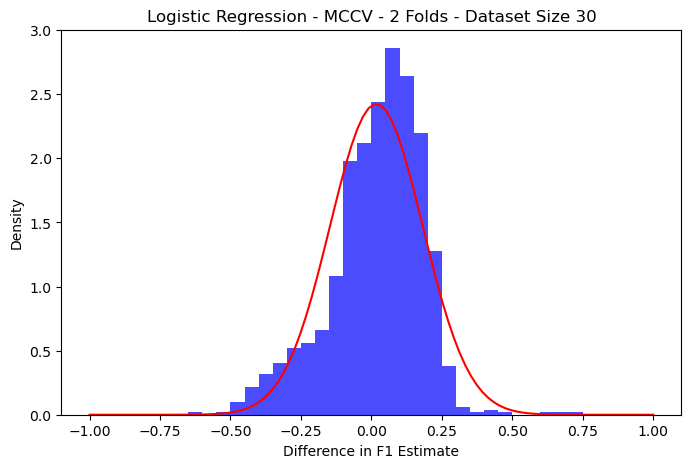

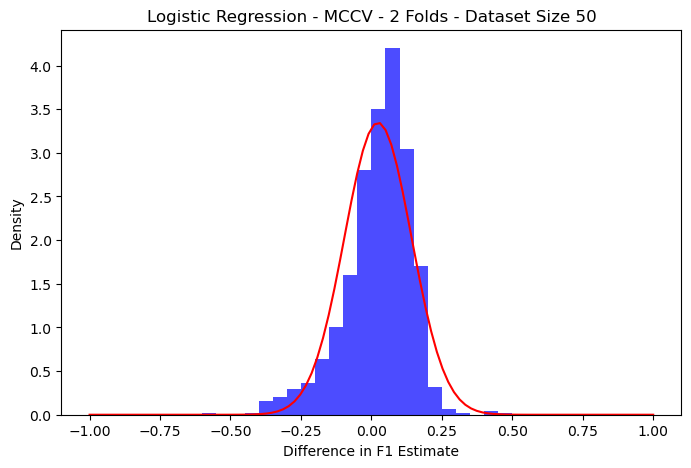

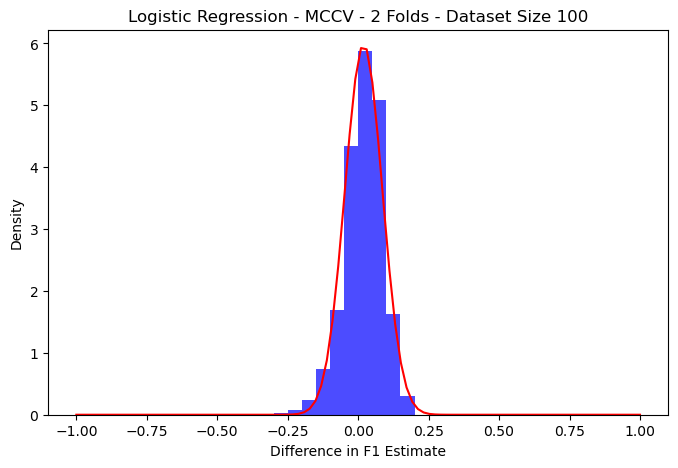

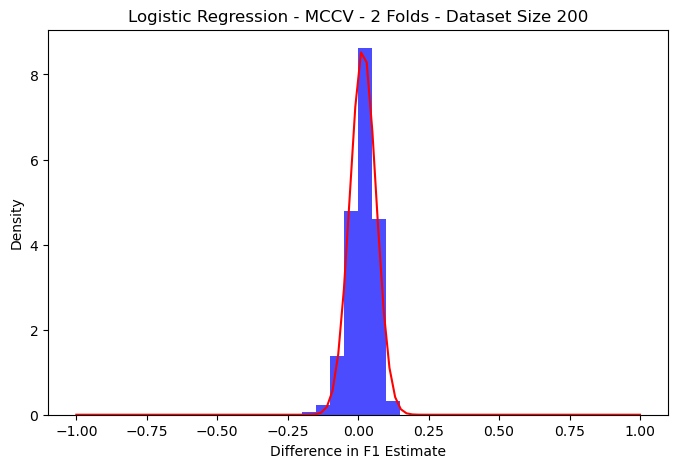

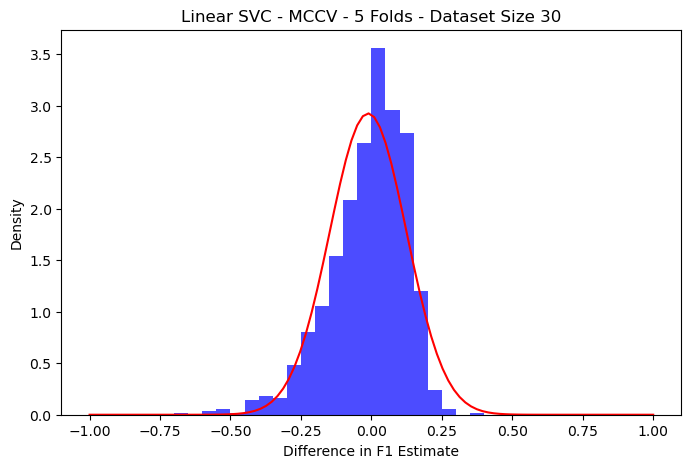

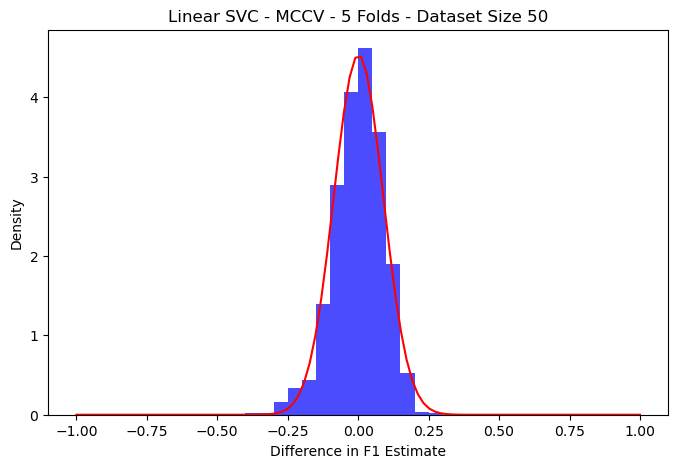

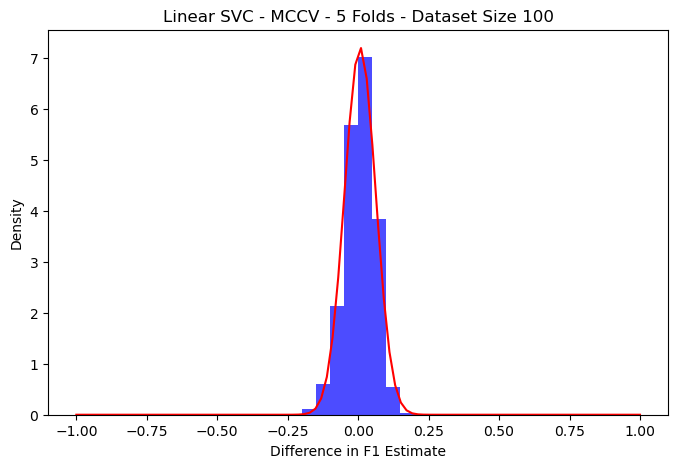

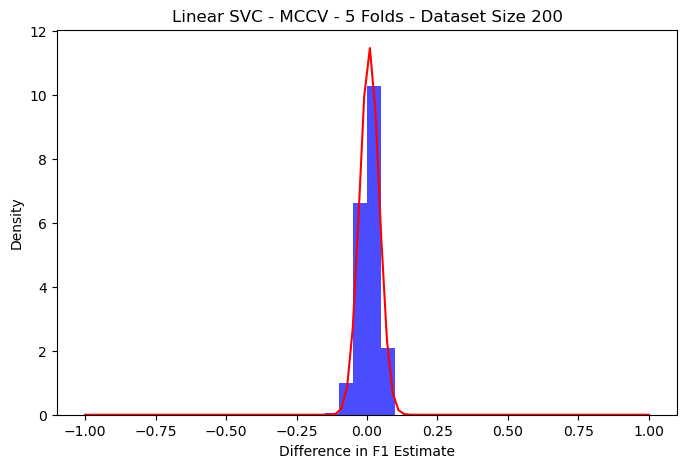

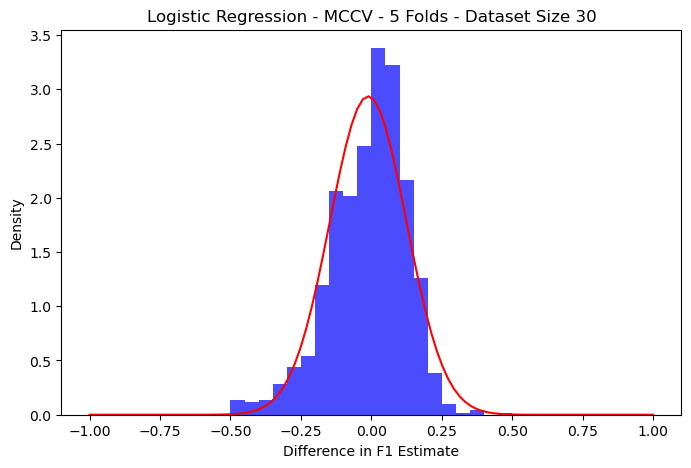

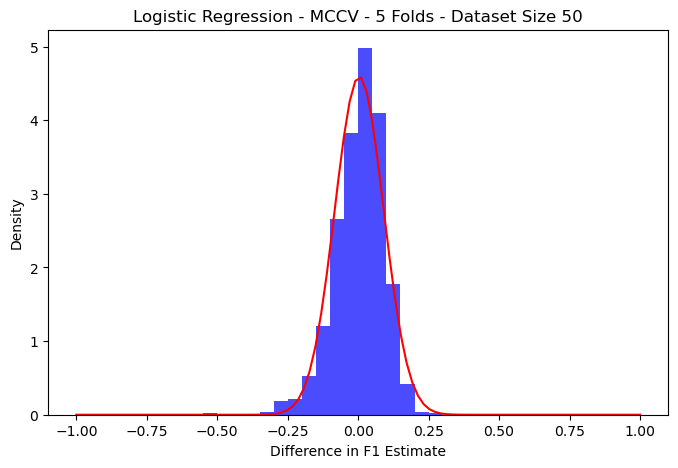

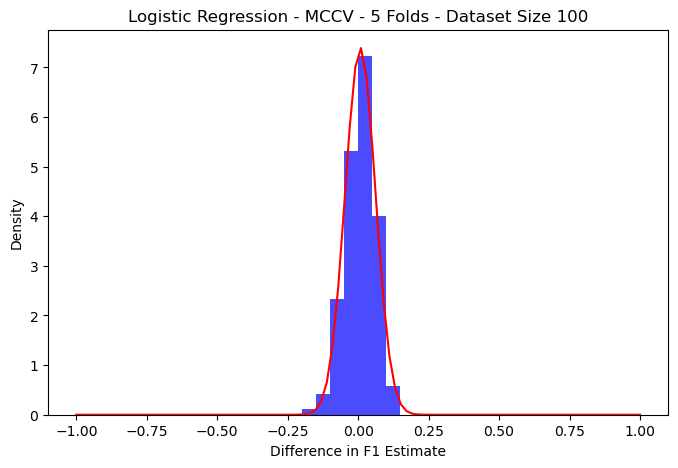

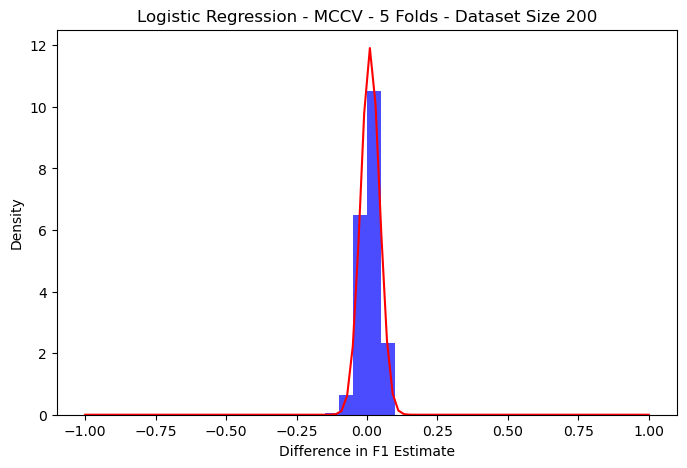

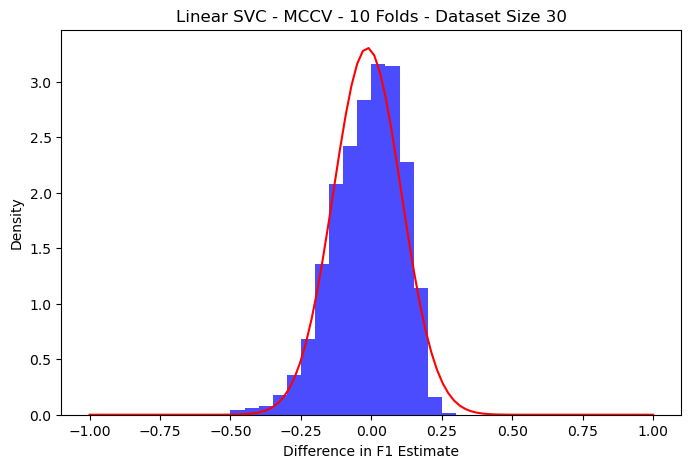

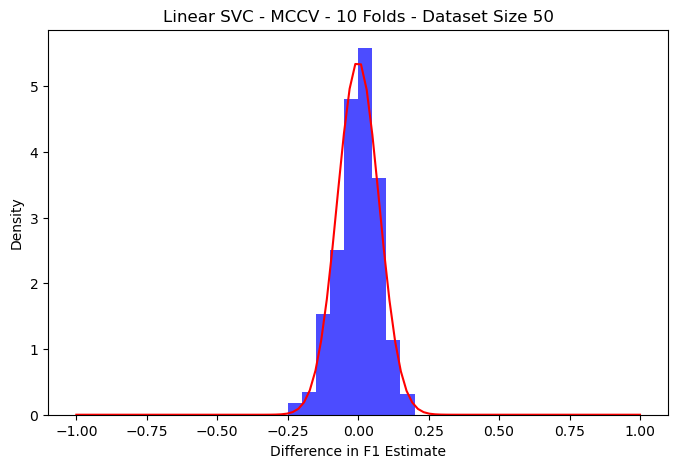

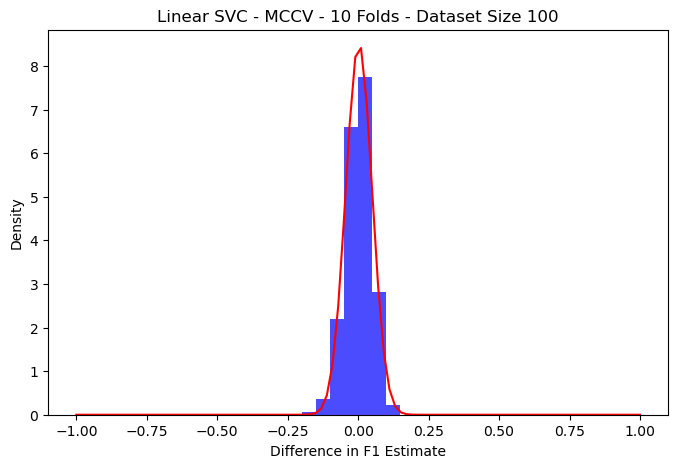

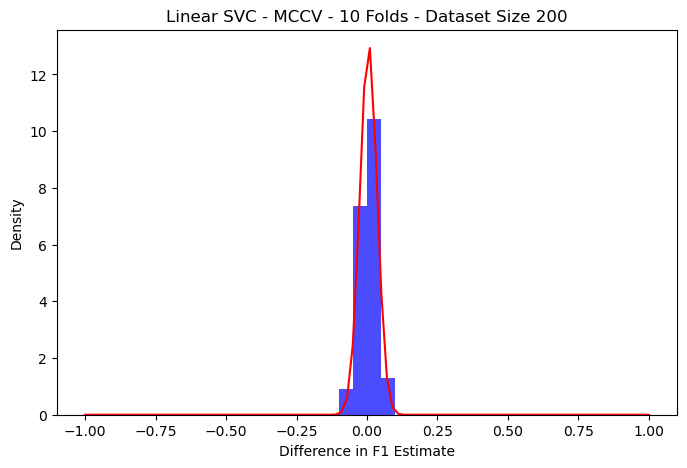

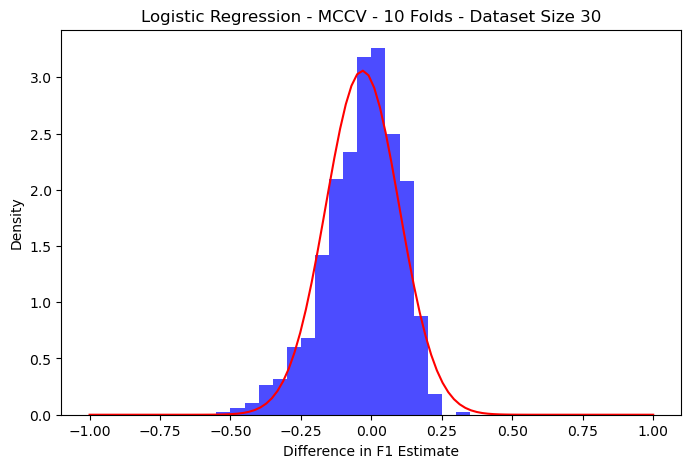

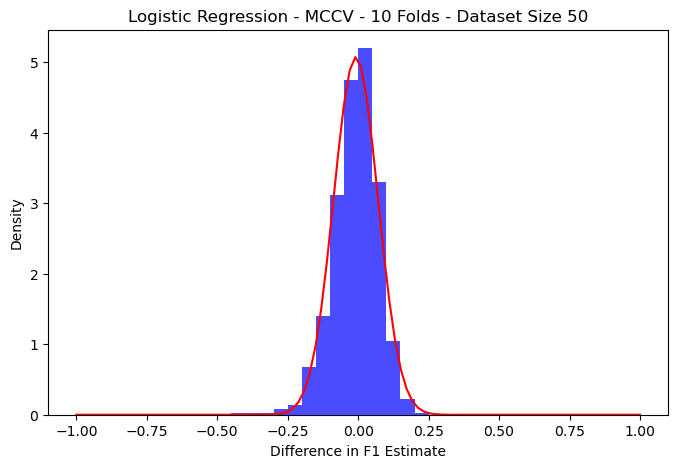

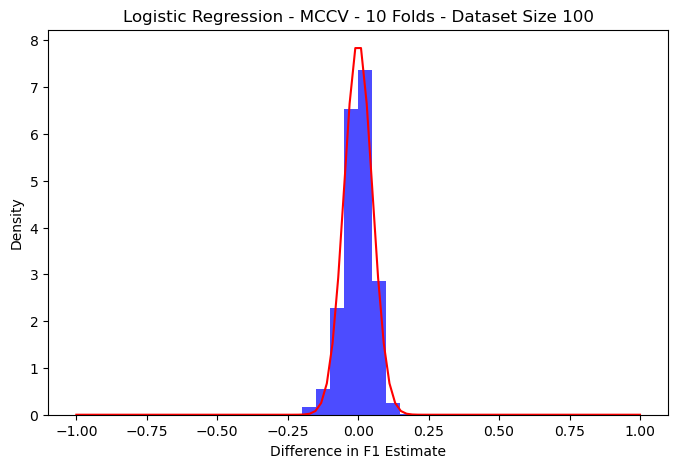

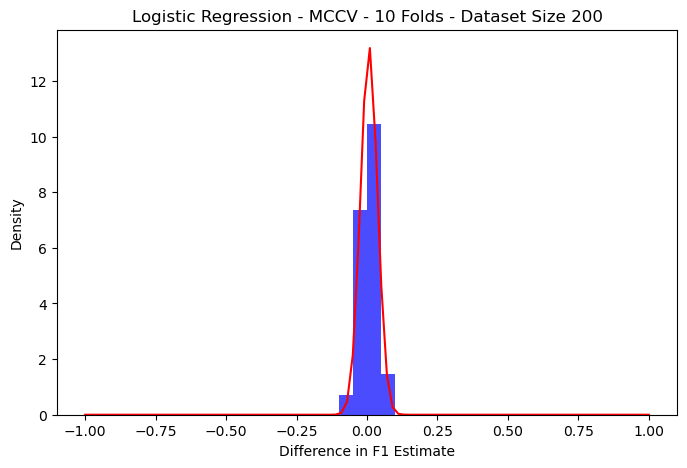

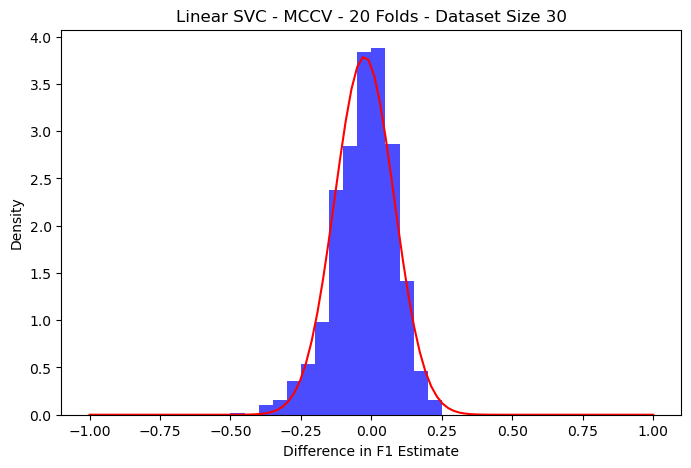

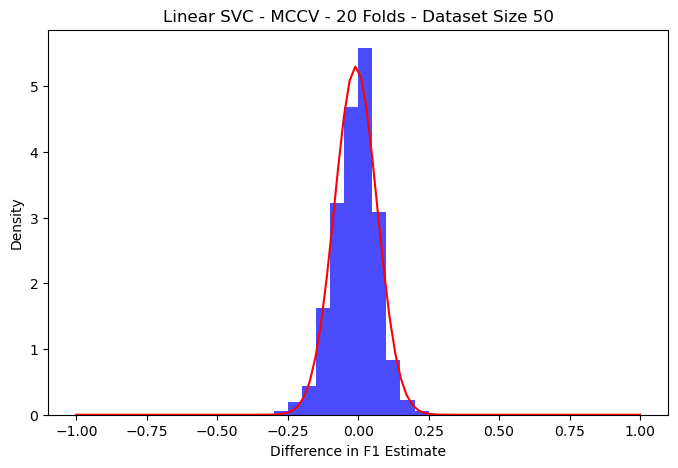

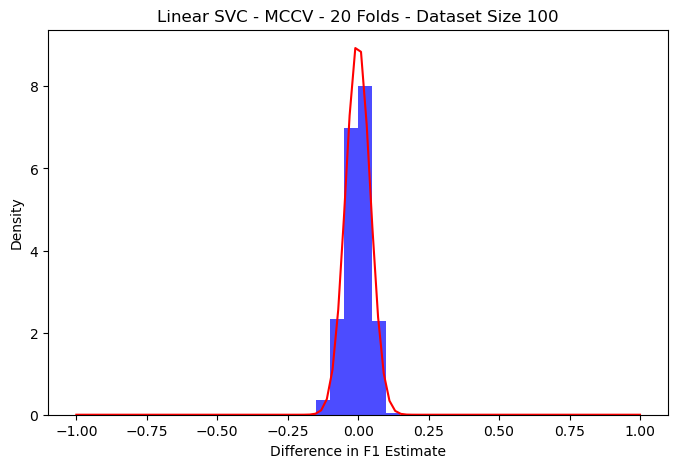

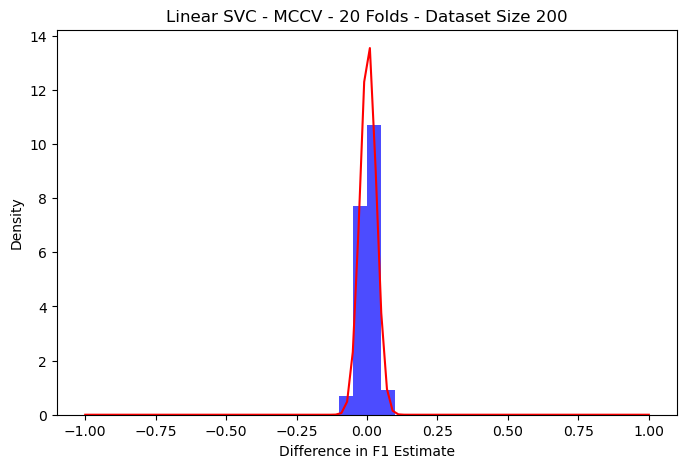

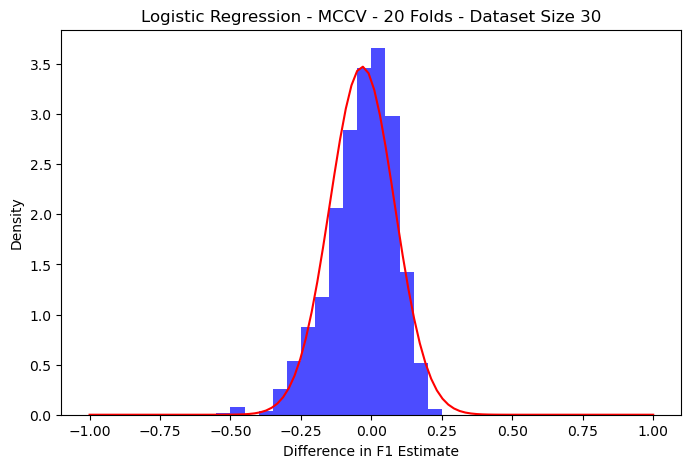

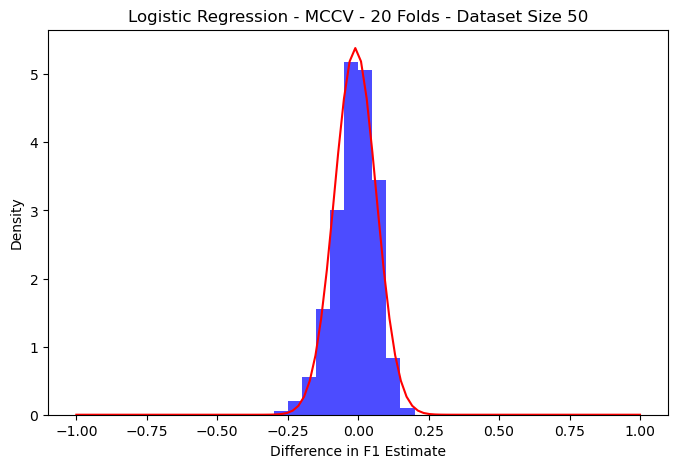

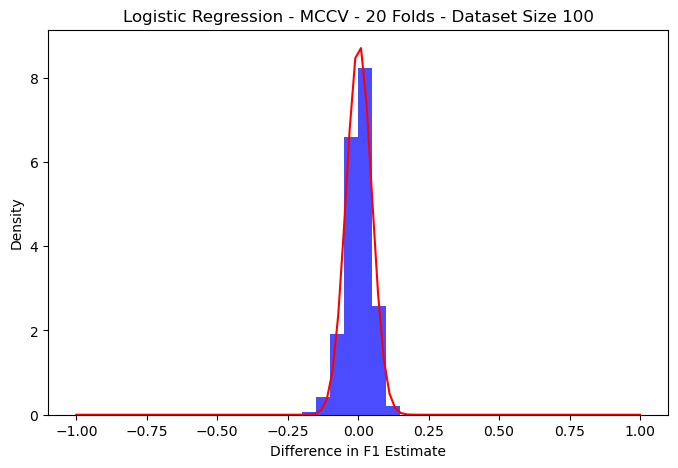

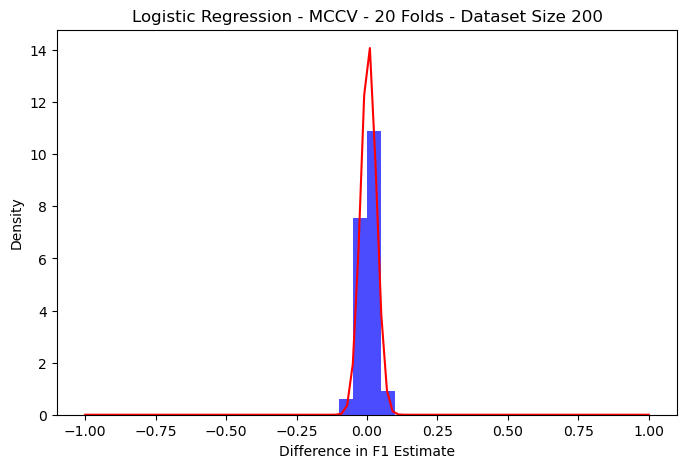

In [574]:
def generate_histogram_with_bell_curve(row, graph_bool = True, dataset_size = None):
    differences = row['differences in f1 estimate']
    mean = np.mean(differences)
    std_dev = np.std(differences)
    
    plt.figure(figsize=(8, 5))
    plt.hist(differences, bins=40, density=True, alpha=0.7, color='blue', label='Histogram', range=(-1, 1))  # Adjust the range here
    
    x = np.linspace(-1, 1, 100)  # Adjust the range here
    y = norm.pdf(x, mean, std_dev)
    plt.plot(x, y, color='red', label='Bell Curve')
    
    title_label = ""
    if graph_bool:
        if row["CV Type"] == 'K-Fold':
            title_label = ' - ' + str(row["num k folds/splits"]) + " Folds"
        elif row ['CV Type'] == 'MCCV':
            title_label = ' - ' + str(row["num k folds/splits"]) + " Splits"
            
    
    plt.xlabel('Difference in F1 Estimate')
    plt.ylabel('Density')
    if dataset_size:
        plt.title(f'{row["Algorithm type"]} - {row["CV Type"]} - {row["num k folds/splits"]} Folds - Dataset Size {row["dataset size"]}')
    #plt.legend()
    else:
        plt.title(f'{row["CV Type"]}' + title_label)
    plt.show()

# Call the function for each row in the DataFrame
for index, row in combined_df.iterrows():
    generate_histogram_with_bell_curve(row,dataset_size = True)


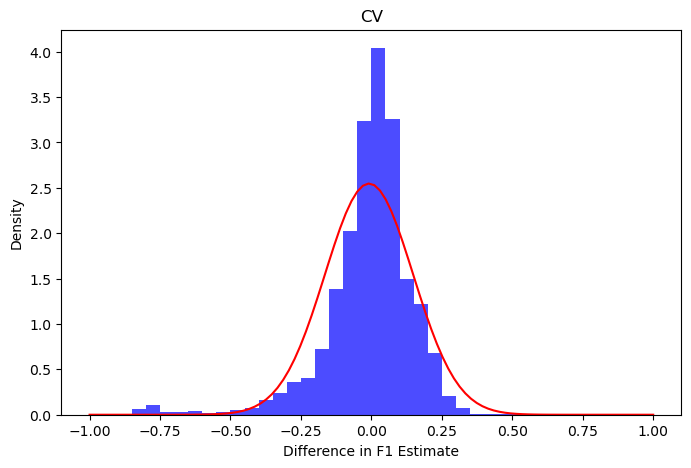

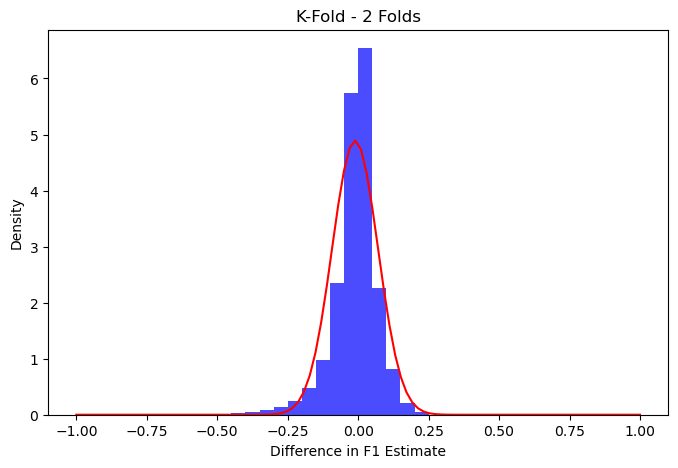

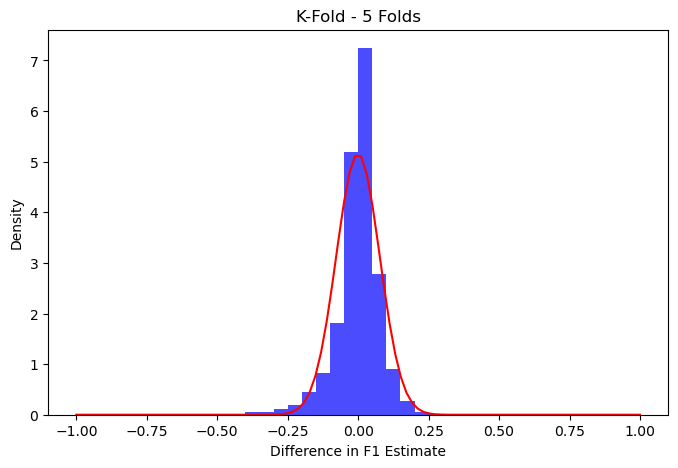

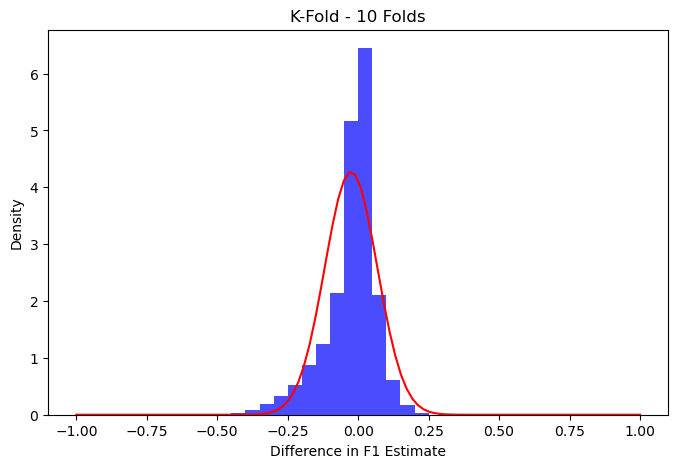

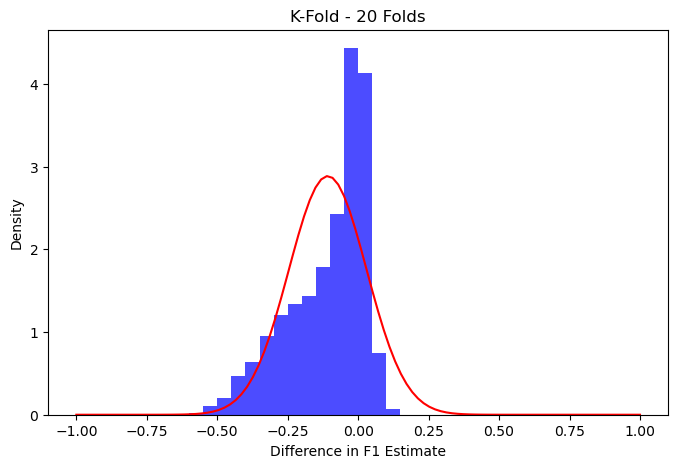

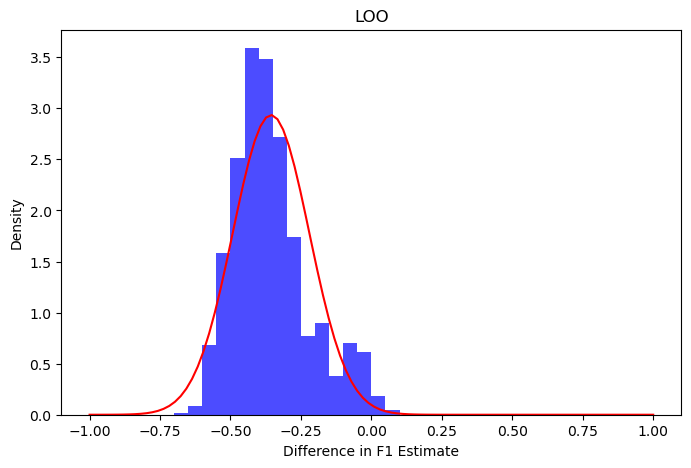

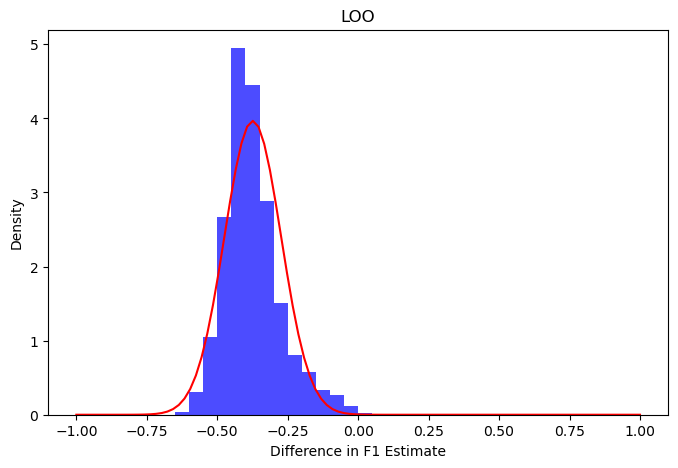

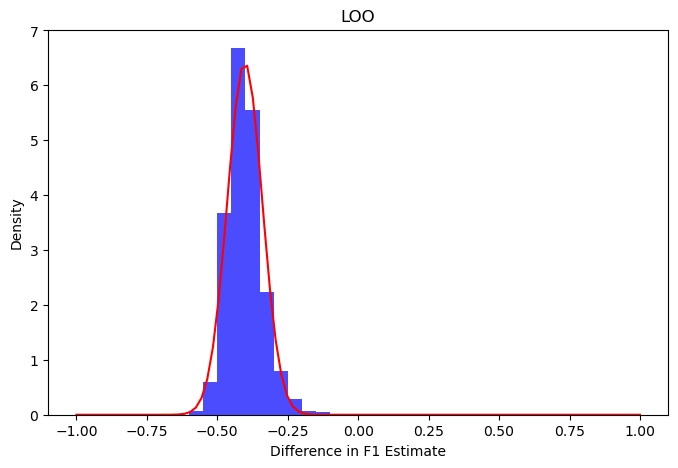

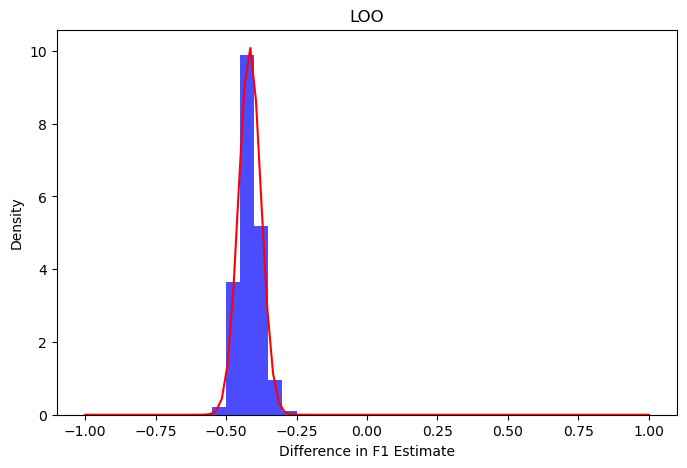

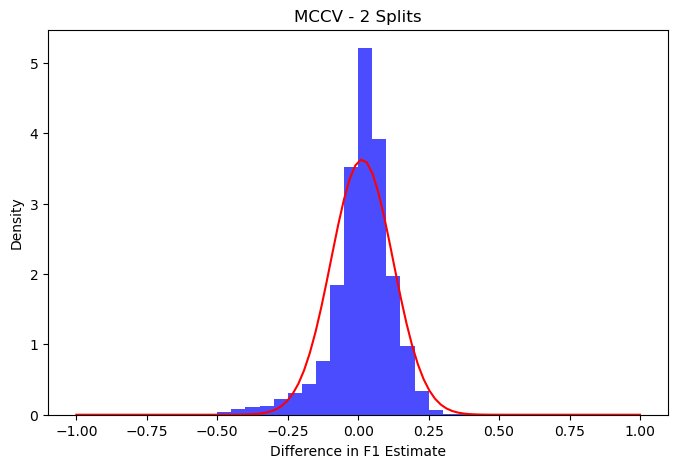

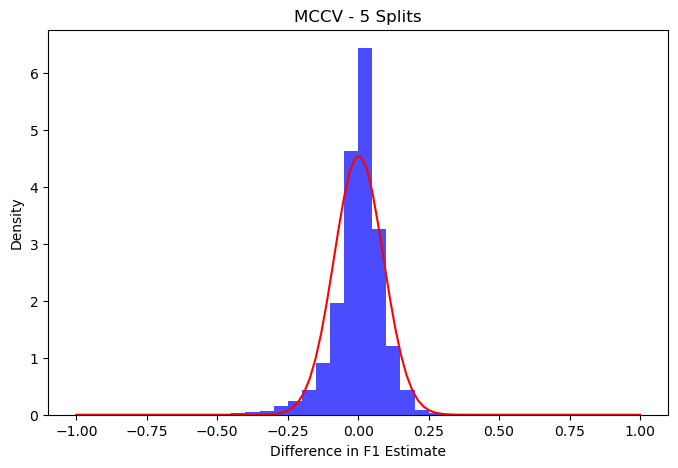

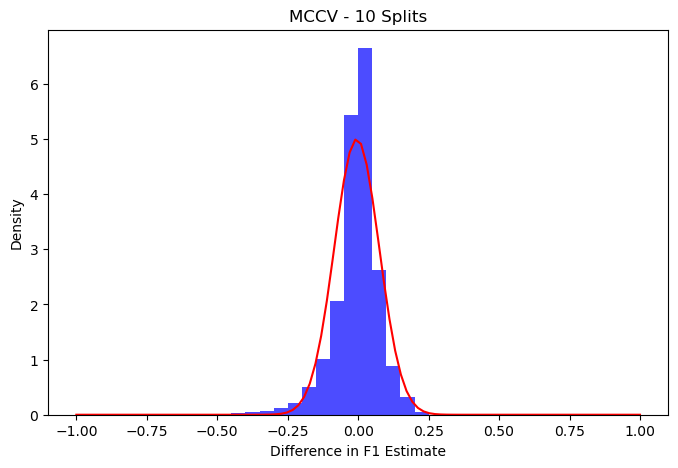

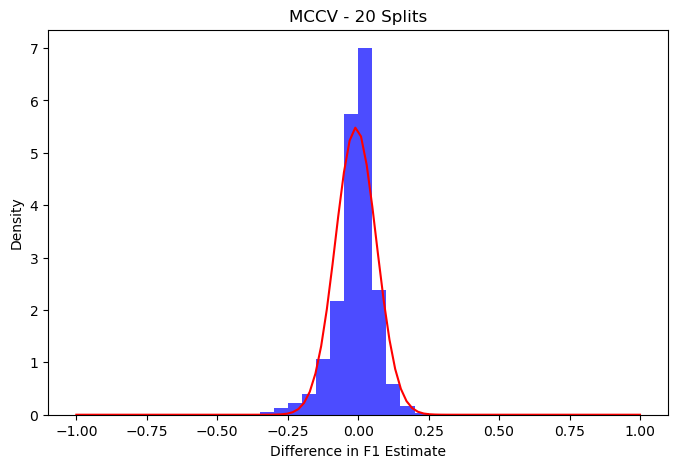

In [569]:
# Call the function for each row in the DataFrame
for index, row in grouped.iterrows():
    generate_histogram_with_bell_curve(row)


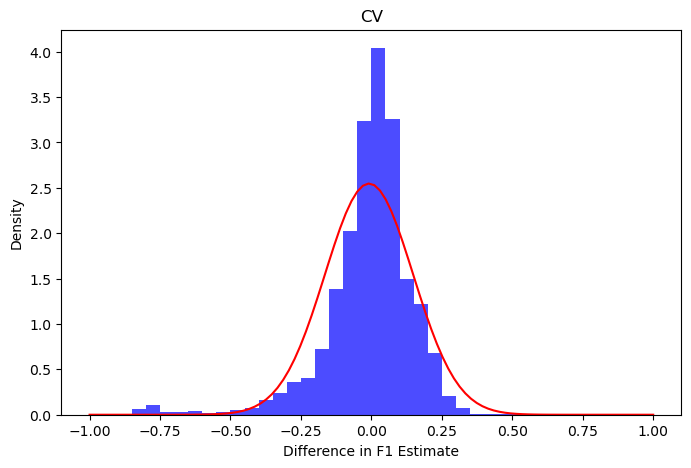

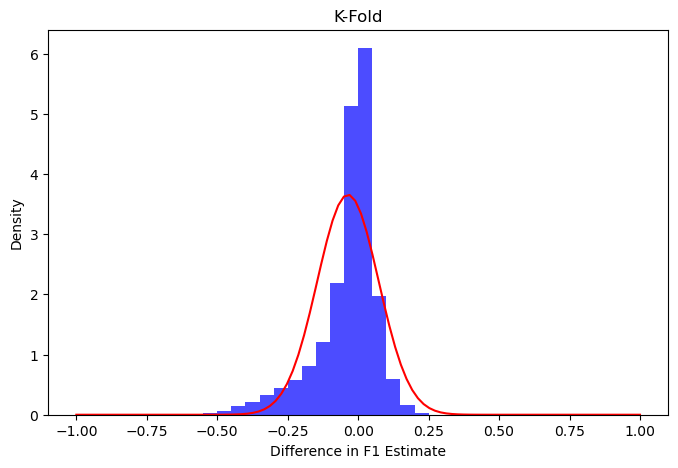

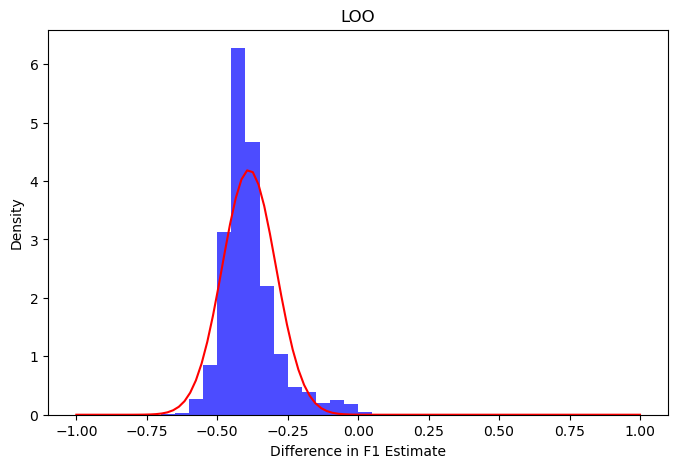

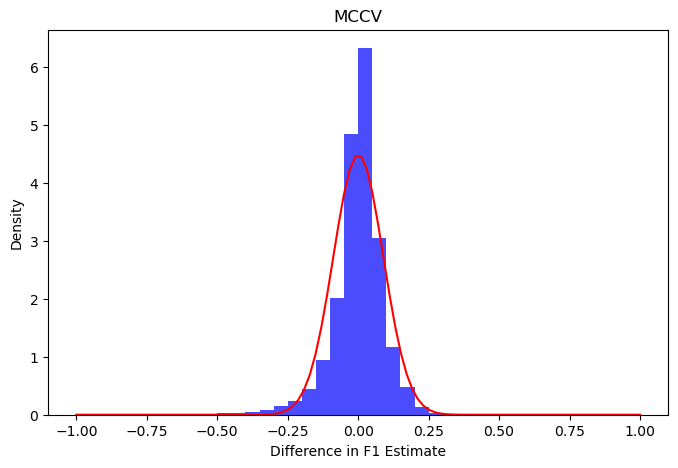

In [575]:
for index, row in grouped2.iterrows():
    generate_histogram_with_bell_curve(row, graph_bool = False)


## Presenting Tables

In [525]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lime' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

def highlight_closest_to_zero(s):
    closest_to_zero = s.abs() == s.abs().min()
    return ['background-color: lime' if v else '' for v in closest_to_zero]

def highlight_farthest_from_zero(s):
    farthest_from_zero = s.abs() == s.abs().max()
    return ['background-color: red' if v else '' for v in farthest_from_zero]

styled_pivot_table = pivot_table.style.apply(highlight_closest_to_zero, axis=0).apply(highlight_farthest_from_zero, axis=0)
styled_pivot_table


def create_pivot(combined_df, metric, algorithm_type_filter=None):
    
    if algorithm_type_filter:
        combined_df = combined_df[combined_df['Algorithm type'] == algorithm_type_filter]

    # Assuming 'combined_df' is already defined
    combined_df = combined_df.sort_values(by=['CV Type', 'num k folds/splits', 'Algorithm type'])

    # Create a new column that combines 'CV Type' and 'num k folds/splits'
    combined_df['CV Technique'] = combined_df['CV Type']  + ' - ' + combined_df['num k folds/splits'].astype(str) + ' folds'


    # Select the relevant columns from the original DataFrame
    selected_columns = ['CV Technique', 'dataset size', metric]

    # Filter the DataFrame for the specified dataset sizes
    dataset_sizes = [30, 50, 100, 200]
    filtered_df = combined_df[combined_df['dataset size'].isin(dataset_sizes)]

    # Create a pivot table
    pivot_table = filtered_df.pivot_table(index='CV Technique', columns='dataset size', values= metric)
    
    loo_rows = pivot_table[pivot_table.index.str.startswith('LOO -')]
    loo_values = loo_rows.mean()

    pivot_table = pivot_table[~pivot_table.index.str.startswith('LOO -')]
    pivot_table.loc['LOO'] = loo_values
    
    
    pivot_table.index = pivot_table.index.where(~pivot_table.index.str.startswith('MCCV'), 
                                                            pivot_table.index.str.replace('folds', 'splits'))
    
        # Define the desired order of index values
    desired_order = [
        'CV - N/A folds',
        'K-Fold - 2 folds', 'K-Fold - 5 folds', 'K-Fold - 10 folds', 'K-Fold - 20 folds',
        'MCCV - 2 splits', 'MCCV - 5 splits', 'MCCV - 10 splits', 'MCCV - 20 splits',
        'LOO'
    ]

    # Reorder the index of the pivot table
    pivot_table_reordered = pivot_table.reindex(desired_order)

    # Display the pivot table with the desired order of rows
    pivot_table_reordered
    
    styled_pivot_table = pivot_table_reordered.style.apply(highlight_max, axis=0).apply(highlight_min, axis=0)


    # Display the pivot table
    return pivot_table_reordered


## Logistic Regression Tables

In [526]:
LR_diff = create_pivot(combined_df, algorithm_type_filter = "Logistic Regression", metric = 'average difference in f1 estimate').style.apply(highlight_closest_to_zero, axis=0).apply(highlight_farthest_from_zero, axis=0)
styled_pivot_table
LR_diff

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,-0.032433,-0.007978,0.000459,0.003475
K-Fold - 2 folds,-0.039510,-0.016962,-0.007109,0.001358
K-Fold - 5 folds,-0.018350,-0.000003,0.004860,0.009628
K-Fold - 10 folds,-0.087521,-0.024396,0.005522,0.007760
K-Fold - 20 folds,-0.243803,-0.137975,-0.028505,0.001586
MCCV - 2 splits,0.017518,0.023322,0.019455,0.017230
MCCV - 5 splits,-0.011550,0.003770,0.007672,0.010864
MCCV - 10 splits,-0.031708,-0.008387,0.000005,0.006957
MCCV - 20 splits,-0.032566,-0.010062,0.002802,0.005302


In [519]:
LR_averagef1 = create_pivot(combined_df, algorithm_type_filter = "Logistic Regression", metric = 'average model f1').style.apply(highlight_max, axis=0).apply(highlight_min, axis=0)
LR_averagef1

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,0.675614,0.768868,0.818369,0.843936
K-Fold - 2 folds,0.767911,0.798734,0.832937,0.850138
K-Fold - 5 folds,0.770892,0.801389,0.832798,0.849945
K-Fold - 10 folds,0.768688,0.802837,0.834467,0.849806
K-Fold - 20 folds,0.759703,0.800949,0.832675,0.849946
MCCV - 2 splits,0.752342,0.795358,0.831328,0.849483
MCCV - 5 splits,0.766686,0.801197,0.833264,0.849478
MCCV - 10 splits,0.767352,0.805107,0.833401,0.849839
MCCV - 20 splits,0.772993,0.803175,0.834616,0.850635


## Linear SVC Tables

In [528]:
SVC_diff = create_pivot(combined_df, algorithm_type_filter = "Linear SVC", metric = 'average difference in f1 estimate').style.apply(highlight_closest_to_zero, axis=0).apply(highlight_farthest_from_zero, axis=0)
styled_pivot_table
SVC_diff

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,-0.025426,-0.013181,-0.000032,0.007808
K-Fold - 2 folds,-0.011523,-0.009935,-0.003530,-0.000479
K-Fold - 5 folds,-0.015855,0.001194,0.005387,0.008103
K-Fold - 10 folds,-0.087005,-0.024706,0.002041,0.006328
K-Fold - 20 folds,-0.285874,-0.140237,-0.027392,-0.001121
MCCV - 2 splits,-0.005869,0.013693,0.014678,0.010697
MCCV - 5 splits,-0.011626,0.001370,0.007001,0.008518
MCCV - 10 splits,-0.014459,-0.000259,0.002681,0.005179
MCCV - 20 splits,-0.024806,-0.008587,-0.000979,0.003974


In [520]:
SVC_averagef1 = create_pivot(combined_df, algorithm_type_filter = "Linear SVC", metric = 'average model f1').style.apply(highlight_max, axis=0).apply(highlight_min, axis=0)
SVC_averagef1

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,0.783527,0.802059,0.826811,0.844921
K-Fold - 2 folds,0.784187,0.811175,0.834097,0.849190
K-Fold - 5 folds,0.787542,0.809761,0.834346,0.848461
K-Fold - 10 folds,0.786271,0.807874,0.832696,0.848371
K-Fold - 20 folds,0.787024,0.808090,0.831793,0.848621
MCCV - 2 splits,0.788303,0.810051,0.833072,0.847873
MCCV - 5 splits,0.785801,0.808695,0.833602,0.848620
MCCV - 10 splits,0.786468,0.811995,0.835335,0.849240
MCCV - 20 splits,0.789359,0.813734,0.836249,0.849377


## Combined Table

In [534]:
com_averagef1 = create_pivot(combined_df, metric = 'average model f1').style.apply(highlight_max, axis=0).apply(highlight_min, axis=0)
com_averagef1

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,0.729571,0.785464,0.822590,0.844429
K-Fold - 2 folds,0.776049,0.804955,0.833517,0.849664
K-Fold - 5 folds,0.779217,0.805575,0.833572,0.849203
K-Fold - 10 folds,0.777479,0.805356,0.833582,0.849088
K-Fold - 20 folds,0.773364,0.804519,0.832234,0.849283
MCCV - 2 splits,0.770323,0.802704,0.832200,0.848678
MCCV - 5 splits,0.776244,0.804946,0.833433,0.849049
MCCV - 10 splits,0.776910,0.808551,0.834368,0.849540
MCCV - 20 splits,0.781176,0.808455,0.835432,0.850006


In [530]:
com_diff = create_pivot(combined_df, metric = 'average difference in f1 estimate').style.apply(highlight_closest_to_zero, axis=0).apply(highlight_farthest_from_zero, axis=0)
styled_pivot_table
com_diff

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,-0.028929,-0.010579,0.000214,0.005641
K-Fold - 2 folds,-0.025516,-0.013449,-0.005319,0.000439
K-Fold - 5 folds,-0.017102,0.000596,0.005123,0.008865
K-Fold - 10 folds,-0.087263,-0.024551,0.003781,0.007044
K-Fold - 20 folds,-0.264839,-0.139106,-0.027948,0.000233
MCCV - 2 splits,0.005825,0.018507,0.017067,0.013964
MCCV - 5 splits,-0.011588,0.002570,0.007336,0.009691
MCCV - 10 splits,-0.023083,-0.004323,0.001343,0.006068
MCCV - 20 splits,-0.028686,-0.009324,0.000911,0.004638


## Time of Runs

In [576]:
com_time = create_pivot(combined_df, metric = 'time')
com_time

dataset size,30,50,100,200
CV Technique,,,,
CV - N/A folds,92.746368,95.324464,96.401839,97.946913
K-Fold - 2 folds,106.688822,112.405034,115.108046,114.882309
K-Fold - 5 folds,133.131255,144.685980,154.105018,174.402545
K-Fold - 10 folds,192.005396,197.541238,211.270010,249.855999
K-Fold - 20 folds,273.734763,289.428747,308.030719,364.997240
MCCV - 2 splits,103.206224,113.826002,118.506060,120.151381
MCCV - 5 splits,130.905387,147.958893,154.895720,168.466109
MCCV - 10 splits,179.858419,199.939612,214.145216,239.805329
MCCV - 20 splits,280.034115,290.763266,305.082780,343.958053
